# Projekt: Der Einfluss des Lebensmittelkonsums in der EU auf die Umwelt

**Zielsetzung:**  Identifizierung von besonders schädlichen Lebensmitteln- und Gruppen, um künftig eine ressourcenschonende & klimafreundliche Lebensmittelproduktion zu gewährleisten

**Fragestellungen:**
* Welche Umweltfaktoren werden beeinflusst? Wie werden diese gewichtet?
* Welche Lebensmittel/Lebensmittelgruppen sind besonders schädlich für die Umwelt?
* Welche Lebensmittel/Lebensmittelgruppen beeinflussen welche Umweltfaktoren und wie stark?
* Welche Lebensmittel/Lebensmittelgruppen verbrauchen die meisten Ressourcen?
* Welche Länder sind besonders umweltschädlich? Welche wenig?
* Überschreitet die EU bestimmte Grenzwerte? In welchen Bereichen?

## Import der Daten

Die zugrundeliegenden Daten beziehen sich auf den Lebensmittelkonsum aller EU Länder und der EU insgesamt. Der Lebensmittelkonsum berechnet sich aus Produktion und internationalem Handel -> **Apparent consumption = Production + Import - Export**.
Quelle Datensatz: https://web.jrc.ec.europa.eu/dashboard/CFP/index.html?bookmark=download

In [6]:
# Import der notwendigen libraries
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np 
import statsmodels.api as sm

In [7]:
# Import Datensatz
food_df = pd.read_excel('/Users/louisafiedler/Documents/Data Analyst Fortbildung/Capstone/food_consumption.xlsx')
food_df

Country Area of consumption Product group   Product  Year  \
0       European Union 27                Food     Beverages      Beer  2010   
1                 Austria                Food     Beverages      Beer  2010   
2                 Belgium                Food     Beverages      Beer  2010   
3                Bulgaria                Food     Beverages      Beer  2010   
4                 Croatia                Food     Beverages      Beer  2010   
...                   ...                 ...           ...       ...   ...   
284643            Romania                Food    Vegetables  Tomatoes  2022   
284644           Slovakia                Food    Vegetables  Tomatoes  2022   
284645           Slovenia                Food    Vegetables  Tomatoes  2022   
284646              Spain                Food    Vegetables  Tomatoes  2022   
284647             Sweden                Food    Vegetables  Tomatoes  2022   

       Impact category  Charactzerized results                   Unit  
0        acidification                0.210668     billion mol H⁺ eq.  
1        acidification                5.935072     million mol H⁺ eq.  
2        acidification                6.510698     million mol H⁺ eq.  
3        acidification                3.542002     million mol H⁺ eq.  
4        acidification                2.321899     million mol H⁺ eq.  
...                ...                     ...                    ...  
284643       water use                0.002946  trillion m³ water eq.  
284644       water use                0.000400  trillion m³ water eq.  
284645       water use                0.000272  trillion m³ water eq.  
284646       water use                0.009805  trillion m³ water eq.  
284647       water use                0.001365  trillion m³ water eq.  

[284648 rows x 8 columns]

In [8]:
# Area of consumption als überflüssige Spalte entfernen
food_df.drop(['Area of consumption'], axis=1, inplace=True)

In [9]:
# Rechtschreibfehler in Spalte korrigieren
food_df.rename(columns={'Charactzerized results': 'Characterized results'}, inplace=True)

In [10]:
# Infos zum Datensatz
food_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284648 entries, 0 to 284647
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Country                284648 non-null  object 
 1   Product group          284648 non-null  object 
 2   Product                284648 non-null  object 
 3   Year                   284648 non-null  int64  
 4   Impact category        284648 non-null  object 
 5   Characterized results  284648 non-null  float64
 6   Unit                   284648 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 15.2+ MB


Der Datensatz besteht aus folgenden Spalten:
* EU-Land
* Lebensmittelgruppe
* Produkt
* Jahr
* Impact Kategorie
* Charakteristische Ergebnis (der Impact Kategorie)
* Einheit

Außer den Spalten Jahr und charakteristisches Ergebnis sind alle Werte kategorisch.

## Datenvorbereitung

Nun schaue ich mir die Spalten und ihre Werte nochmal genauer an. Außerdem identifiziere ich mögliche Nullwerte & Duplikate.

In [14]:
# NaN-Werte prüfen
food_df.isnull().any()

Country                  False
Product group            False
Product                  False
Year                     False
Impact category          False
Characterized results    False
Unit                     False
dtype: bool

Es sind keine Nullwerte vorhanden.

In [16]:
#Duplikate prüfen
food_df.duplicated().any()

False

Es sind auch keine Duplikate vorhanden.

In [18]:
# Liste der EU-Länder
food_df['Country'].unique()

array(['European Union 27', 'Austria', 'Belgium', 'Bulgaria', 'Croatia',
       'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France',
       'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia',
       'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland',
       'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden'],
      dtype=object)

Die Länderspalte enthält neben den Ländern auch die EU insgesamt als Wert. Das ist wichtig für die spätere Analyse.

In [20]:
# Liste der Produktgruppen
food_df['Product group'].unique()

array(['Beverages', 'Cereal-based products', 'Coffee and tea',
       'Confectionary products', 'Dairy', 'Eggs', 'Fish and seafood',
       'Fruits', 'Legume-based products', 'Legumes', 'Meat',
       'Nuts and seeds', 'Oils', 'Pre-prepared meals', 'Tubers',
       'Vegetables'], dtype=object)

In [21]:
# Produktgruppen und Produkte anzeigen
food_df.groupby('Product group')['Product'].unique().explode()

Product group
Beverages                               Beer
Beverages                      Mineral water
Beverages                               Wine
Cereal-based products                  Bread
Cereal-based products                  Pasta
Cereal-based products                 Quinoa
Cereal-based products                   Rice
Coffee and tea                        Coffee
Coffee and tea                           Tea
Confectionary products              Biscuits
Confectionary products             Chocolate
Confectionary products                 Sugar
Dairy                                 Butter
Dairy                                 Cheese
Dairy                                   Milk
Eggs                                    Eggs
Fish and seafood                         Cod
Fish and seafood                      Salmon
Fish and seafood                      Shrimp
Fish and seafood               Tuna (canned)
Fruits                                Apples
Fruits                               Avoc

Die Liste aller Lebensmittelgruppen und ihrer repräsentativen Produkte. Nun schaue ich mir die Verteilung der Lebensmittelgruppen im Datensatz an.

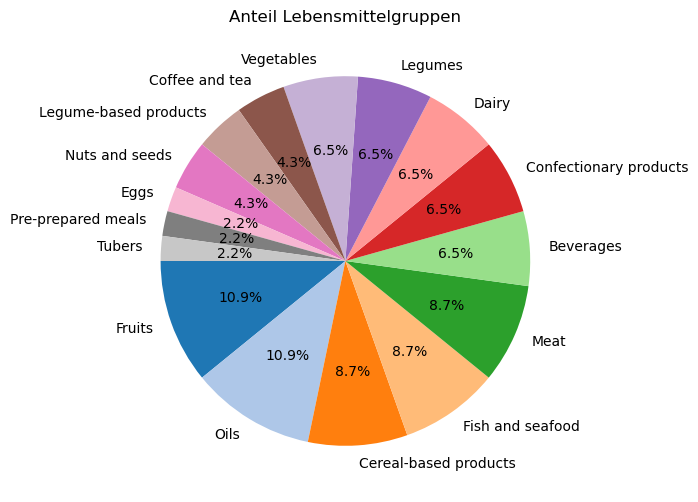

In [23]:
# Tortendiagramm für die Verteilung der Lebensmittelgruppen
plt.figure(figsize=(10, 6))
plt.title("Anteil Lebensmittelgruppen")
palette_color = sns.color_palette('tab20')
plot = plt.pie(
    food_df['Product group'].value_counts(),
    labels=food_df['Product group'].value_counts().index,
    autopct='%1.1f%%',
    startangle=180,
    colors=palette_color
)
plt.show()

Obst & Öle sind am meisten im Datensatz vertreten, mit jeweils 5 repräsentativen Produkten. Am wenigsten vertreten sind Knollen, Fertiggerichte und Eier mit jeweils nur einem repräsentativen Produkt.

Da es im Datenframe Daten zur EU insgesamt und für die Länder gibt, ist es sinnvoll, zwei Datenframes zu erstellen um EU-weit bzw. länderspezifisch zu analysieren.

In [26]:
# EU-Dataframe und Länder-Dataframe erstellen
eu_df = food_df[food_df['Country'] == 'European Union 27']
country_df = food_df[food_df['Country'] != 'European Union 27']

In [27]:
# Spalte mit dem Land für EU-Datenframe entfernen
eu_df = eu_df.drop(columns=['Country'])

Die EU-Daten und die Länder-Daten haben unterschiedliche Einheiten:

In [29]:
# Impact Kategorien und ihre Einheiten (EU)
eu_df[['Impact category', 'Unit']].groupby('Impact category').value_counts()

Impact category                   Unit                     
acidification                     billion mol H⁺ eq.           598
climate change                    billion tonnes CO₂ eq.       598
ecotoxicity, freshwater           trillion CTUe                598
eutrophication, freshwater        thousand tonnes P eq.        598
eutrophication, marine            million tonnes N eq.         598
eutrophication, terrestrial       billion mol N eq.            598
human toxicity, cancer            thousand CTUh                598
human toxicity, non-cancer        thousand CTUh                598
ionising radiation                million tonnes U-235 eq.     598
land use                          trillion Pt.                 598
ozone depletion                   thousand tonnes CFC-11 eq    598
particulate matter                disease incidence (x1000)    598
photochemical ozone formation     million tonnes NMVOC eq.     598
resource use, fossil              exajoule (EJ)                598
re

In [30]:
# Impact Kategorien und ihre Einheiten (Länder)
country_df[['Impact category', 'Unit']].groupby('Impact category').value_counts()

Impact category                   Unit                     
acidification                     million mol H⁺ eq.           16146
climate change                    million tonnes CO₂ eq.       16146
ecotoxicity, freshwater           billion CTUe                 16146
eutrophication, freshwater        thousand tonnes P eq.        16146
eutrophication, marine            thousand tonnes N eq.        16146
eutrophication, terrestrial       billion mol N eq.            16146
human toxicity, cancer            thousand CTUh                16146
human toxicity, non-cancer        thousand CTUh                16146
ionising radiation                thousand tonnes U-235 eq.    16146
land use                          trillion Pt.                 16146
ozone depletion                   tonnes CFC-11 eq             16146
particulate matter                disease incidence (x1000)    16146
photochemical ozone formation     thousand tonnes NMVOC eq.    16146
resource use, fossil              petajoule

Bevor ich in die weitere Analyse gehe, ergibt es Sinn weitere Informationen zu den einzelnen Impact Kategorien einzuholen. Zum einen eine Erklärung der einzelnen Impacts, zu finden hier: https://green-business.ec.europa.eu/environmental-footprint-methods/life-cycle-assessment-ef-methods_en . Zum anderen die Gewichtung der Impacts im Single Weighted Score. Der Single Weighted Score gibt den allgemeinen Umweltschaden der Produkte an und setze sich aus allen anderen Impact Kategorien zusammen. Für die Gewichtung ziehe ich folgende Tabelle aus MySQL hinzu: (Quelle: https://publications.jrc.ec.europa.eu/repository/handle/JRC126257)

In [32]:
# Import der Impact Assessment Tabelle von MySQL
import pymysql
from sqlalchemy import create_engine
engine = create_engine('mysql+pymysql://root:pw@localhost/capstone')
query = 'SELECT * FROM impact_assessment'
impact_assessment_df = pd.read_sql(query, con=engine)
impact_assessment_df

impact_category               unit  \
0                      acidification          mol H+ eq   
1                     climate change          kg CO2 eq   
2            ecotoxicity, freshwater               CTUe   
3         eutrophication, freshwater            kg P eq   
4             eutrophication, marine            kg N eq   
5        eutrophication, terrestrial           mol N eq   
6             human toxicity, cancer               CTUh   
7         human toxicity, non-cancer               CTUh   
8                 ionising radiation        kBq U235 eq   
9                           land use                Pt.   
10                   ozone depletion       kg CFC-11 eq   
11                particulate matter  disease incidence   
12     photochemical ozone formation        kg NMVOC eq   
13              resource use, fossil     megajoule (MJ)   
14  resource use, mineral and metals           kg Sb eq   
15                         water use        m3 water eq   

    global_normalization_factor  weighting_factor  planetary_boundary  
0                     55.600000            0.0620        1.000000e+12  
1                   7550.000000            0.2106        6.810000e+12  
2                  56700.000000            0.0192        1.310000e+14  
3                      1.610000            0.0280        5.810000e+09  
4                     19.500000            0.0296        2.010000e+11  
5                    177.000000            0.0371        6.130000e+12  
6                      0.000017            0.0184        9.620000e+05  
7                      0.000129            0.0213        4.100000e+06  
8                   4220.000000            0.0501        5.270000e+14  
9                 819000.000000            0.0794        3.980000e+15  
10                     0.052300            0.0631        5.390000e+08  
11                     0.000595            0.0896        5.160000e+05  
12                    40.900000            0.0478        4.070000e+11  
13                 65000.000000            0.0832        2.240000e+14  
14                     0.063600            0.0755        2.190000e+08  
15                 11500.000000            0.0851        1.820000e+14

Die Tabelle enthält weitere Informationen zu den einzelnen Impact Kategorien: ihre Normalization factors, die Gewichte und die jeweiligen weltweiten Grenzwerte (Planetary Boundaries). Die Tabelle passe ich noch etwas an, bevor ich sie in die Datenanalyse mit einbeziehe.

In [34]:
# Spalten umbenennen für Einheitlichkeit
impact_assessment_df.rename(columns={'impact_category': 'Impact category', 'unit': 'Unit', 'global_normalization_factor': 'Global normalization factor', 'weighting_factor': 'Weighting factor', 'planetary_boundary': 'Planetary boundary'}, inplace=True)

Schauen wir uns nun die Gewichtungen der Impact Kategorien an.

In [36]:
# Sortieren nach den größten Gewichten
impact_assessment_df.sort_values(by='Weighting factor', ascending=False)

Impact category               Unit  \
1                     climate change          kg CO2 eq   
11                particulate matter  disease incidence   
15                         water use        m3 water eq   
13              resource use, fossil     megajoule (MJ)   
9                           land use                Pt.   
14  resource use, mineral and metals           kg Sb eq   
10                   ozone depletion       kg CFC-11 eq   
0                      acidification          mol H+ eq   
8                 ionising radiation        kBq U235 eq   
12     photochemical ozone formation        kg NMVOC eq   
5        eutrophication, terrestrial           mol N eq   
4             eutrophication, marine            kg N eq   
3         eutrophication, freshwater            kg P eq   
7         human toxicity, non-cancer               CTUh   
2            ecotoxicity, freshwater               CTUe   
6             human toxicity, cancer               CTUh   

    Global normalization factor  Weighting factor  Planetary boundary  
1                   7550.000000            0.2106        6.810000e+12  
11                     0.000595            0.0896        5.160000e+05  
15                 11500.000000            0.0851        1.820000e+14  
13                 65000.000000            0.0832        2.240000e+14  
9                 819000.000000            0.0794        3.980000e+15  
14                     0.063600            0.0755        2.190000e+08  
10                     0.052300            0.0631        5.390000e+08  
0                     55.600000            0.0620        1.000000e+12  
8                   4220.000000            0.0501        5.270000e+14  
12                    40.900000            0.0478        4.070000e+11  
5                    177.000000            0.0371        6.130000e+12  
4                     19.500000            0.0296        2.010000e+11  
3                      1.610000            0.0280        5.810000e+09  
7                      0.000129            0.0213        4.100000e+06  
2                  56700.000000            0.0192        1.310000e+14  
6                      0.000017            0.0184        9.620000e+05

Die **wichtigste Kategorie ist Climate Change**, also die globale Erwärmung durch Treibhausgasemissionen. Die **zweitwichtigste Kategorie ist Particulate Matter**, womit die Gesundheitsschäden durch Feinstaubbelastung gemeint sind. Danach folgen **Wasserverbrauch und fossiler Ressourcenverbrauch**. Die Indikatoren fließen entsprechend ihrer Gewichte in den Single Weighted Score ein, der den gesamten Umweltschaden bewertet. In der weiteren Analyse werde ich mich vor allem auf die wichtigsten vier Impacts fokussieren.

## Datenanalyse

### Betrachtung der numerischen Variablen (Impact Kategorien)

#### Deskriptive Statistik

Im ersten Schritt untersuche ich die numerischen Variablen. Ich muss die Tabelle zuerst filtern und pivotieren, um anschließend die deskriptiven Statistiken abrufen zu können.

In [42]:
# Für die EU-Tabelle:
# Entfernen aller Spalten, außer 'Impact category' & 'Characterized results'
eu_impact_df = eu_df.drop(columns=['Product group', 'Product', 'Year', 'Unit'])

In [43]:
# Pivotieren der Tabelle, Impact Kategorien als Spalten
eu_impact_df = eu_impact_df.pivot(columns=['Impact category'], values='Characterized results')

In [44]:
# Deskriptive Statistiken der Impact Kategorien
eu_impact_df.describe()

Impact category  acidification  climate change  ecotoxicity, freshwater  \
count               598.000000      598.000000               598.000000   
mean                  0.504414        0.028110                 1.476804   
std                   1.058750        0.047631                 3.023654   
min                   0.000080        0.000002                 0.000012   
25%                   0.043270        0.004711                 0.076948   
50%                   0.095429        0.011693                 0.290981   
75%                   0.239546        0.023272                 1.209688   
max                   4.890294        0.270488                15.229652   

Impact category  eutrophication, freshwater  eutrophication, marine  \
count                            598.000000              598.000000   
mean                               3.391088                0.196080   
std                                5.919212                0.381112   
min                                0.000011                0.000017   
25%                                0.391309                0.017811   
50%                                0.939827                0.071371   
75%                                2.957655                0.133984   
max                               25.071242                2.117261   

Impact category  eutrophication, terrestrial  human toxicity, cancer  \
count                             598.000000            5.980000e+02   
mean                                2.170070            2.185931e-02   
std                                 4.706456            3.293806e-02   
min                                 0.000268            4.157699e-07   
25%                                 0.151676            3.218744e-03   
50%                                 0.363794            1.038758e-02   
75%                                 0.931788            2.466884e-02   
max                                21.754898            2.119997e-01   

Impact category  human toxicity, non-cancer  ionising radiation    land use  \
count                            598.000000          598.000000  598.000000   
mean                               0.743021            0.477706    1.058310   
std                                1.153706            0.540158    1.872337   
min                                0.000010            0.000052   -0.039763   
25%                                0.078841            0.111266    0.096835   
50%                                0.256692            0.305262    0.373938   
75%                                0.861109            0.683552    1.163282   
max                                5.681432            2.620117   11.845188   

Impact category  ozone depletion  particulate matter  \
count               5.980000e+02          598.000000   
mean                2.323705e-02            3.692477   
std                 5.471741e-02            7.537873   
min                 1.651459e-07            0.000690   
25%                 2.459526e-04            0.322054   
50%                 1.887992e-03            0.678532   
75%                 1.811192e-02            2.181796   
max                 3.312043e-01           35.008152   

Impact category  photochemical ozone formation  resource use, fossil  \
count                               598.000000            598.000000   
mean                                  0.059363              0.163521   
std                                   0.073559              0.195018   
min                                   0.000011              0.000014   
25%                                   0.009957              0.038299   
50%                                   0.040147              0.101888   
75%                                   0.076946              0.231384   
max                                   0.379620              1.132084   

Impact category  resource use, mineral and metals  single weighted score  \
count                                  598.000000           5.980000e+02   
mean             

Generell scheint es große Unterschiede bei den Produkten zu geben. Minimum und Maximumwerte liegen teilweise weit auseinander. Climate Change z.B. mit 0,000002 Milliarden Tonnen (2000 Tonnen) CO₂ Ausstoß als Minimum und 0,27 Milliarden (270.000.000 Tonnen) als Maximum. Ich werde im späteren Verlauf noch die Produkte & Produktgruppen mit den niedrigsten und höchsten Werten betrachten.
Eine weitere Auffälligkeit ist der negative Minimalwert bei Land use. Es scheint also Produkte zu geben, die nicht immer einen Land- oder Speziesverlust bedeuten, sondern auch einen Gewinn.

In [46]:
# Für die Country-Tabelle
# Entfernen aller Spalten außer 'Impact Category' & 'Characterized results'
country_impact_df = country_df.drop(columns=['Country', 'Product group', 'Product', 'Year', 'Unit'])

In [47]:
# Pivotieren der Tabelle, Impact Kategorien als Spalten
country_impact_df = country_impact_df.pivot(columns=['Impact category'], values='Characterized results')

In [48]:
# Deskriptive Statistiken
country_impact_df.describe()

Impact category  acidification  climate change  ecotoxicity, freshwater  \
count             16146.000000    16146.000000             16146.000000   
mean                 19.808421        1.100526                56.259211   
std                  84.137503        3.843221               217.627689   
min                  -8.544432       -0.311369               -27.606669   
25%                   0.260900        0.029492                 0.840413   
50%                   1.536443        0.154855                 4.910005   
75%                   7.408807        0.619536                27.512447   
max                1152.401792       68.157329              3837.553279   

Impact category  eutrophication, freshwater  eutrophication, marine  \
count                          16146.000000            16146.000000   
mean                               0.135256                7.697756   
std                                0.477732               30.837015   
min                               -0.043627               -2.802178   
25%                                0.002907                0.139508   
50%                                0.016330                0.861301   
75%                                0.068414                3.522916   
max                                7.038900              498.934240   

Impact category  eutrophication, terrestrial  human toxicity, cancer  \
count                           16146.000000            16146.000000   
mean                                0.085055                0.000857   
std                                 0.372186                0.002733   
min                                -0.038007               -0.000221   
25%                                 0.000946                0.000023   
50%                                 0.005661                0.000125   
75%                                 0.027966                0.000570   
max                                 5.126560                0.053419   

Impact category  human toxicity, non-cancer  ionising radiation      land use  \
count                          16146.000000        16146.000000  16146.000000   
mean                               0.029346           18.876943      0.042208   
std                                0.097542           49.028290      0.152402   
min                               -0.008902           -4.700711     -0.015089   
25%                                0.000661            0.794914      0.000834   
50%                                0.003618            3.561986      0.004978   
75%                                0.016757           14.319423      0.023413   
max                                1.431602          660.214528      2.984739   

Impact category  ozone depletion  particulate matter  \
count               16146.000000        16146.000000   
mean                    0.876968            0.144708   
std                     4.012590            0.600423   
min                    -0.089663           -0.060228   
25%                     0.003038            0.002161   
50%                     0.028266            0.011707   
75%                     0.245348            0.055741   
max                    83.456563            8.249701   

Impact category  photochemical ozone formation  resource use, fossil  \
count                             16146.000000          16146.000000   
mean                                  2.377636              6.414958   
std                                   6.976253             17.254177   
min                                  -1.295848             -2.074060   
25%                                   0.082462              0.268871   
50%                                   0.407547              1.201335   
75%                                   1.647222              4.681986   
max                                 118.700224            285.261496   

Impact category  resource use, mineral and metals  single weighted score  \
count                                16146.000000           16146.000000   

In allen Kategorien findet man hier negative Werte als Minimum. Das bedeutet, es gibt in jeder Kategorie Produkte, die zeitweise einen positiven Einfluss auf den jeweiligen Impact haben können. Diese Produkte sind natürlich wichtig für eine ressourcenschonende und klimafreundliche Lebensmittelproduktion. Wir schauen uns im weiteren Verlauf der Analyse noch die harmlostesten und schädlichsten Produkte und Lebensmittelgruppen an. Auch hier sind wieder großen Spannen zwischen Minimum- und Maximumwerten zu erkennen.

#### Verteilungen der numerischen Variablen

Nun schau ich mir noch die Verteilung einzelner Impact Variablen der Länder an. Ich betrachte den Single Weighted Score und die 3 wichtigsten Impact Kategorien Climate Change, Particulate Matter und Water Use.

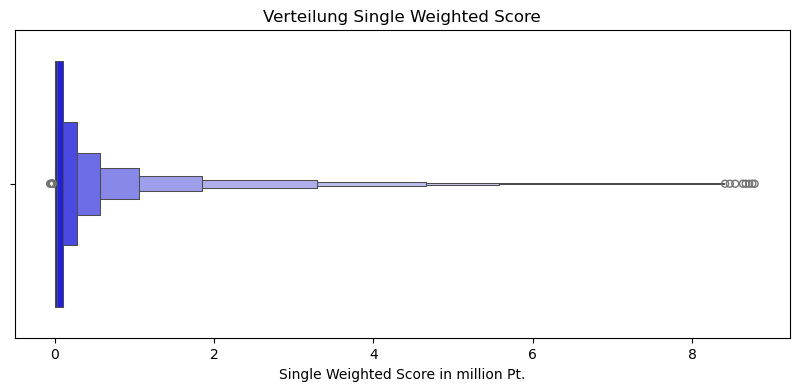

In [52]:
# Verteilung Single Weighted Score (Boxenplot)
plt.figure(figsize=(10,4))
sns.boxenplot(data=country_impact_df, x='single weighted score', color='b')
plt.xlabel('Single Weighted Score in million Pt.')
plt.title('Verteilung Single Weighted Score')
plt.show()

Beim Single Weighted Score liegen die meisten Werte zwischen 0 und 1. Es gibt aber auch ein paar Werte die deutlich im höheren Bereich über 8 liegen und auch vereinzelte Werte im Minusbereich.

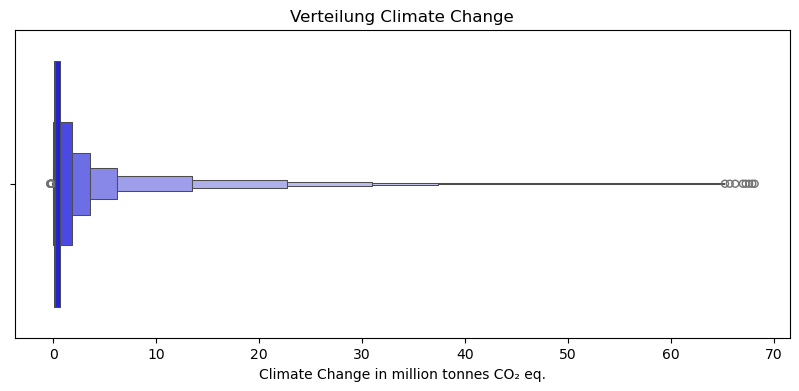

In [54]:
# Verteilung Climate change (Boxenplot)
plt.figure(figsize=(10,4))
sns.boxenplot(data=country_impact_df, x='climate change', color='b')
plt.xlabel('Climate Change in million tonnes CO₂ eq.')
plt.title('Verteilung Climate Change')
plt.show()

Beim Climate Change liegen die meisten Werte zwischen 0 und 6 Millionen Tonnen CO₂. Auch hier gibt es einige Werte im deutlich höheren Bereich zwischen 65 und 70 Millionen Tonnen CO₂. Die Verteilungen sehen sehr ähnlich aus, was auch logisch ist, da sich der Single Weighted Score zu ca. 21 % aus dem Indikator Climate Change ergibt.

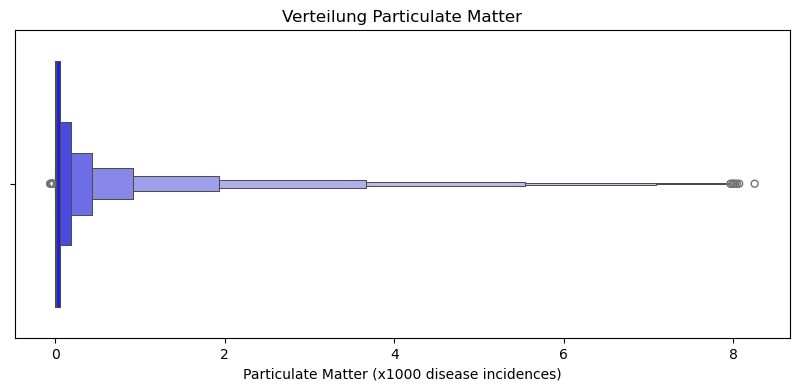

In [56]:
# Verteilung Particulate Matter (Boxenplot)
plt.figure(figsize=(10,4))
sns.boxenplot(data=country_impact_df, x='particulate matter', color='b')
plt.xlabel('Particulate Matter (x1000 disease incidences)')
plt.title('Verteilung Particulate Matter')
plt.show()

Die meisten Inzidenzen durch Feinstaub liegen zwischen 0 und 1000. Es gibt auch hier einige Werte im oberen Bereich bei ca. 8000, sowie negative Werte.

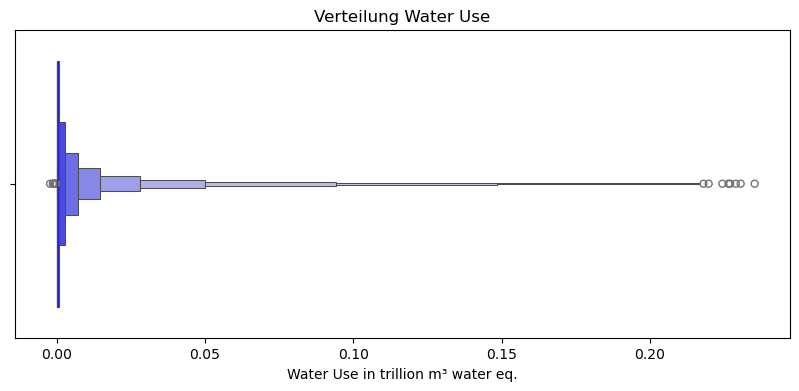

In [58]:
# Verteilung von Water use (Boxenplot)
plt.figure(figsize=(10,4))
sns.boxenplot(data=country_impact_df, x='water use', color='b')
plt.xlabel('Water Use in trillion m³ water eq.')
plt.title('Verteilung Water Use')
plt.show()

Der Wasserverbrauch liegt verstärkt zwischen 0 und 0,02 Billiarden m³. Manche Werte liegen sogar über 0,2 Billiarden m³, auch hier gibt es wieder Werte im negativen Bereich.

#### Impact Kategorien im Zeitverlauf

Den Single Weighted Score und die wichtigsten Impact Kategorien im Zeitverlauf mit Trendlinie hab ich in Power BI dargestellt. Beim Single Weighted Score habe ich zusätzlich eine lineare Regression durchgeführt, um einen linearen Zeittrend zu belegen.

Der EU-weite Single Weighted Score aller Lebensmittelgruppen zusammengefasst zeigt einen linearen Trend nach oben. Das heißt, der durch Lebensmittelkonsum entstandene Umweltschaden insgesamt nimmt stetig zu.

Nachdem ich nun die numerischen Variablen und ihre Verteilungen im Datensatz genauer untersucht habe, betrachte ich als nächstes die Lebensmittelgruppen.

### Betrachtung der Lebensmittelgruppen

**Welche Lebensmittelgruppen sind besonders schädlich?** Dafür schaue ich mir den EU-weiten Single Weighted Score der Lebensmittelgruppen im Jahresdurchschnitt an. 
Hierfür erstelle ich zuerst einen Score-Datenframe für die Lebensmittelgruppen und berechne dann für jede Gruppe den Jahresdurchschnitt.

#### EU-weiter Umweltschaden (Single Weighted Score) der Lebensmittelgruppen

In [66]:
# Erstellen einer Single Weighted Score Tabelle
score_df = eu_df[(eu_df['Impact category'] == 'single weighted score')]
score_df = score_df.rename(columns={'Characterized results': 'Single weighted score'}) 
score_df

Product group   Product  Year        Impact category  \
420        Beverages      Beer  2010  single weighted score   
896        Beverages      Beer  2011  single weighted score   
1372       Beverages      Beer  2012  single weighted score   
1848       Beverages      Beer  2013  single weighted score   
2324       Beverages      Beer  2014  single weighted score   
...              ...       ...   ...                    ...   
282688    Vegetables  Tomatoes  2018  single weighted score   
283164    Vegetables  Tomatoes  2019  single weighted score   
283640    Vegetables  Tomatoes  2020  single weighted score   
284116    Vegetables  Tomatoes  2021  single weighted score   
284592    Vegetables  Tomatoes  2022  single weighted score   

        Single weighted score        Unit  
420                  0.003964  billion pt  
896                  0.004019  billion pt  
1372                 0.004076  billion pt  
1848                 0.003833  billion pt  
2324                 0.003924  billion pt  
...                       ...         ...  
282688               0.003648  billion pt  
283164               0.003394  billion pt  
283640               0.003245  billion pt  
284116               0.004061  billion pt  
284592               0.003683  billion pt  

[598 rows x 6 columns]

In [67]:
# Single Weighted Score der Lebensmittelgruppen summiert über die Produkte im Jahresschnitt
product_group_score_df = score_df[['Product group', 'Year', 'Single weighted score',]].groupby(['Product group', 'Year']).sum().reset_index()
product_group_score_average = product_group_score_df[['Product group', 'Single weighted score']].groupby(['Product group']).mean().reset_index().sort_values(by='Single weighted score', ascending=False)
product_group_score_average

Product group  Single weighted score
10                    Meat               0.075986
4                    Dairy               0.041339
0                Beverages               0.014310
12                    Oils               0.008317
6         Fish and seafood               0.008203
11          Nuts and seeds               0.007724
7                   Fruits               0.007142
14                  Tubers               0.006813
3   Confectionary products               0.006570
15              Vegetables               0.005554
1    Cereal-based products               0.005188
2           Coffee and tea               0.004217
5                     Eggs               0.003769
13      Pre-prepared meals               0.000756
9                  Legumes               0.000539
8    Legume-based products               0.000089

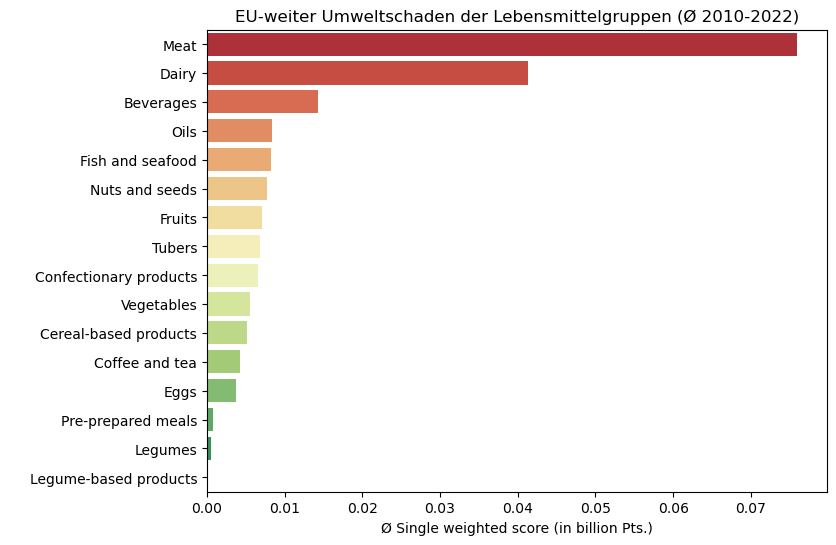

In [68]:
# Grafische Darstellung der Tabelle:
# Barplot der Scores je Lebensmittelgruppe im Jahresschnitt
plt.figure(figsize=(8,6))
sns.barplot(data=product_group_score_average, x='Single weighted score', y='Product group', hue='Product group', palette='RdYlGn')
plt.title('EU-weiter Umweltschaden der Lebensmittelgruppen (Ø 2010-2022)')
plt.xlabel('Ø Single weighted score (in billion Pts.)')
plt.ylabel(' ')
plt.show()

Fleischprodukte haben eindeutig den höchsten durchschnittlichen Single Weighted Score mit 0,076, gefolgt von Milchprodukten mit 0,041 und Getränken mit 0,014. Ganz unten sind Hülsenfrüchte (0,00054) und Lebensmittel basierend auf Hülsenfrüchten (0,000089), sowie Fertiggerichte (0,00076).

Nun betrachten wir das Ganze noch für die vier wichtigsten Impact Kategorien Climate Change, Particulate Matter, Wasserverbrauch und fossiler Ressourcenverbrauch.

#### Climate Change, Particulate Matter, Wasserverbrauch & fossiler Ressourcenverbrauch der Lebensmittelgruppen

In [72]:
# Climate Change der Lebensmittelgruppen summiert über die Produkte im Jahresschnitt
climate_df = eu_df[(eu_df['Impact category'] == 'climate change')]
climate_df = climate_df.rename(columns={'Characterized results': 'Climate change'}) 
product_group_climate_df = climate_df[['Product group', 'Year', 'Climate change',]].groupby(['Product group', 'Year']).sum().reset_index()
product_group_climate_average = product_group_climate_df[['Product group', 'Climate change']].groupby(['Product group']).mean().reset_index().sort_values(by='Climate change', ascending=False)
product_group_climate_average

Product group  Climate change
10                    Meat        0.548518
4                    Dairy        0.295015
0                Beverages        0.070048
6         Fish and seafood        0.059307
3   Confectionary products        0.058886
7                   Fruits        0.049286
12                    Oils        0.040944
1    Cereal-based products        0.037757
15              Vegetables        0.036968
14                  Tubers        0.023384
5                     Eggs        0.022112
2           Coffee and tea        0.021883
11          Nuts and seeds        0.020453
13      Pre-prepared meals        0.005405
9                  Legumes        0.001779
8    Legume-based products        0.001334

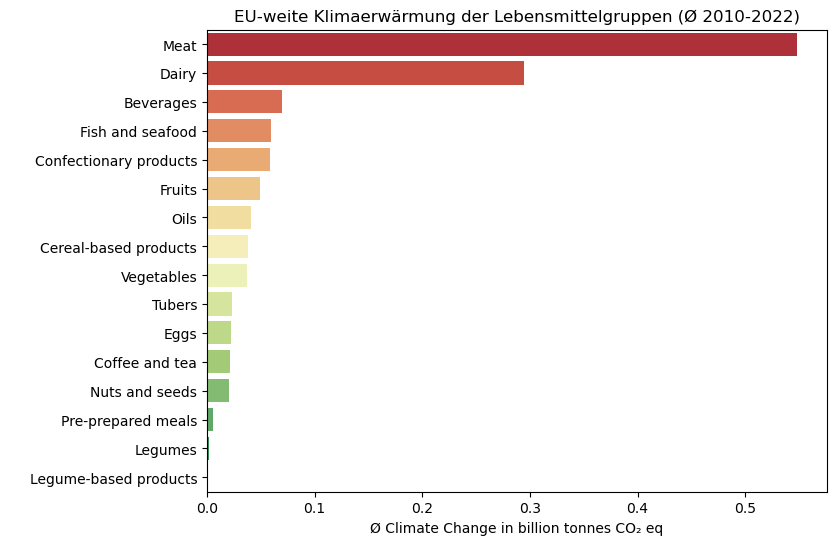

In [73]:
# Grafische Darstellung der Tabelle
# Barplot von Climate Change je Lebensmittelgruppe im Jahresschnitt
plt.figure(figsize=(8,6))
sns.barplot(data=product_group_climate_average, x='Climate change', y='Product group', hue='Product group', palette='RdYlGn')
plt.title('EU-weite Klimaerwärmung der Lebensmittelgruppen (Ø 2010-2022)')
plt.xlabel('Ø Climate Change in billion tonnes CO₂ eq')
plt.ylabel(' ')
plt.show()

Hier sind auch wieder Fleisch- und Milchprodukte mit Abstand die schädlichsten Lebensmittelgruppen. Mit über 0,5 Milliarden Tonnen CO₂ (Fleisch) bzw. ca. 0,3 Milliarden Tonnen CO₂ (Milchprodukte).  Danach folgen Getränke, Fisch und Meeresfrüchte, sowie Süßwaren.

In [75]:
# Particulate Matter der Lebensmittelgruppen summiert über die Produkte im Jahresschnitt
particulate_df = eu_df[(eu_df['Impact category'] == 'particulate matter')]
particulate_df = particulate_df.rename(columns={'Characterized results': 'Particulate matter'}) 
product_group_particulate_df = particulate_df[['Product group', 'Year', 'Particulate matter',]].groupby(['Product group', 'Year']).sum().reset_index()
product_group_particulate_average = product_group_particulate_df[['Product group', 'Particulate matter']].groupby(['Product group']).mean().reset_index().sort_values(by='Particulate matter', ascending=False)
product_group_particulate_average

Product group  Particulate matter
10                    Meat           82.475256
4                    Dairy           51.458900
15              Vegetables            4.667662
6         Fish and seafood            4.642963
5                     Eggs            4.184030
0                Beverages            3.992964
11          Nuts and seeds            3.658564
12                    Oils            3.454452
2           Coffee and tea            2.733029
3   Confectionary products            2.324826
1    Cereal-based products            2.149221
7                   Fruits            1.963240
14                  Tubers            1.238000
13      Pre-prepared meals            0.507147
9                  Legumes            0.386308
8    Legume-based products            0.017390

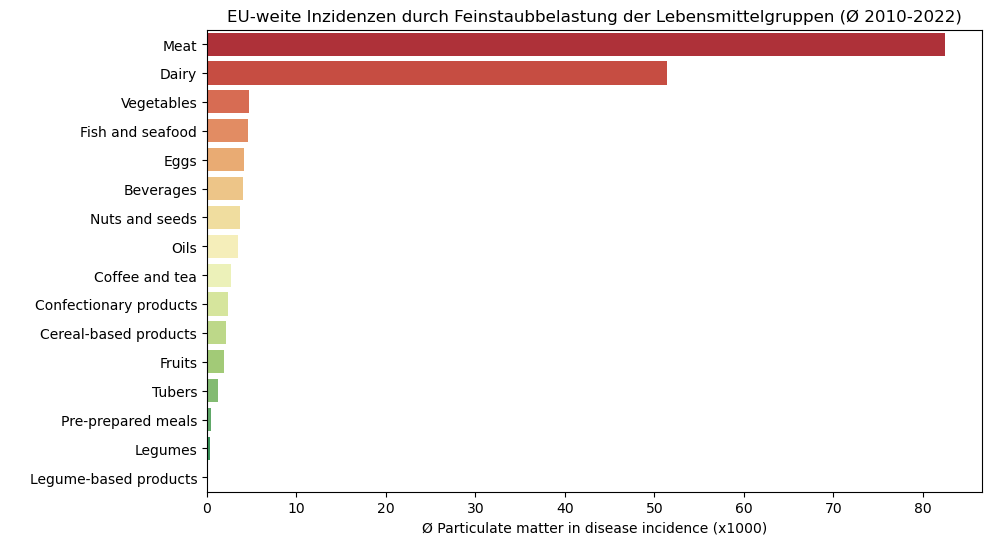

In [76]:
# Grafische Darstellung der Tabelle
# Barplot von Particulate Matter je Lebensmittelgruppe im Jahresschnitt
plt.figure(figsize=(10,6))
sns.barplot(data=product_group_particulate_average, x='Particulate matter', y='Product group', hue='Product group', palette='RdYlGn')
plt.title('EU-weite Inzidenzen durch Feinstaubbelastung der Lebensmittelgruppen (Ø 2010-2022)')
plt.xlabel('Ø Particulate matter in disease incidence (x1000)')
plt.ylabel(' ')
plt.show()

Auch hier liegen wieder Fleisch-und Milchprodukte mit Abstand ganz vorne (über 80k bzw. 50k). Danach liegt diesmal Gemüse fast gleichauf mit Fisch und Meeresfrüchten.

In [78]:
# Water use der Lebensmittelgruppen summiert über die Produkte im Jahresschnitt
water_df = eu_df[(eu_df['Impact category'] == 'water use')]
water_df = water_df.rename(columns={'Characterized results': 'Water use'}) 
product_group_water_df = water_df[['Product group', 'Year', 'Water use',]].groupby(['Product group', 'Year']).sum().reset_index()
product_group_water_average = product_group_water_df[['Product group', 'Water use']].groupby(['Product group']).mean().reset_index().sort_values(by='Water use', ascending=False)
product_group_water_average

Product group  Water use
0                Beverages   0.879317
11          Nuts and seeds   0.541539
7                   Fruits   0.339154
3   Confectionary products   0.234513
10                    Meat   0.196542
1    Cereal-based products   0.125505
6         Fish and seafood   0.118997
15              Vegetables   0.089622
4                    Dairy   0.068674
12                    Oils   0.037702
2           Coffee and tea   0.031083
5                     Eggs   0.016793
13      Pre-prepared meals   0.007741
14                  Tubers   0.004767
9                  Legumes   0.001457
8    Legume-based products   0.000394

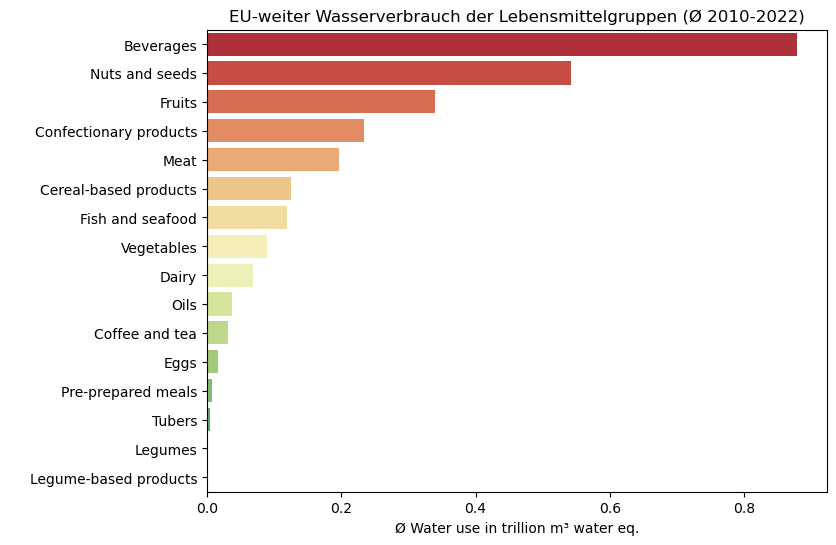

In [79]:
# Grafische Darstellung der Tabelle
# Barplot Wasserverbrauch je Lebensmittelgruppe im Jahresschnitt
plt.figure(figsize=(8,6))
sns.barplot(data=product_group_water_average, x='Water use', y='Product group', hue='Product group', palette='RdYlGn')
plt.title('EU-weiter Wasserverbrauch der Lebensmittelgruppen (Ø 2010-2022)')
plt.xlabel('Ø Water use in trillion m³ water eq.')
plt.ylabel(' ')
plt.show()

Beim Wasserverbrauch sieht das Ranking diesmal etwas anders aus. Ganz oben mit über 0,8 Billiarden m³ Wasser sind Getränke. Danach folgen Nüsse & Kerne, dann Obst. Unten liegen wieder Hülsenfrüchte und auf Hülsenfrüchte basierende Lebensmittel, diesmal sind auch Kartoffeln unten anzufinden.

In [81]:
# Fossiler Ressourcenverbrauch der Lebensmittelgruppen summiert über die Produkte im Jahresschnitt
fossil_df = eu_df[(eu_df['Impact category'] == 'resource use, fossil')]
fossil_df = fossil_df.rename(columns={'Characterized results': 'Resource use, fossil'}) 
product_group_fossil_df = fossil_df[['Product group', 'Year', 'Resource use, fossil',]].groupby(['Product group', 'Year']).sum().reset_index()
product_group_fossil_average = product_group_fossil_df[['Product group', 'Resource use, fossil']].groupby(['Product group']).mean().reset_index().sort_values(by='Resource use, fossil', ascending=False)
product_group_fossil_average

Product group  Resource use, fossil
10                    Meat              2.036497
4                    Dairy              1.127700
0                Beverages              1.047168
6         Fish and seafood              0.719572
15              Vegetables              0.407690
7                   Fruits              0.384216
1    Cereal-based products              0.368270
3   Confectionary products              0.296104
12                    Oils              0.263441
2           Coffee and tea              0.230756
14                  Tubers              0.221539
11          Nuts and seeds              0.208601
5                     Eggs              0.125498
13      Pre-prepared meals              0.057013
9                  Legumes              0.021754
8    Legume-based products              0.006127

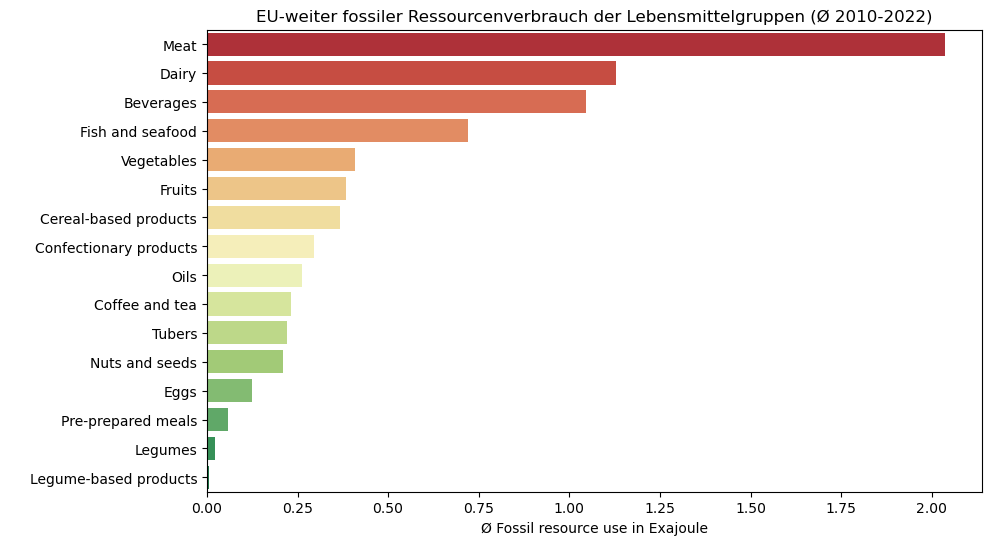

In [82]:
# Grafische Darstellung der Tabelle
# Barplot fossiler Ressourcenverbrauch je Lebensmittelgruppe im Jahresschnitt
plt.figure(figsize=(10,6))
sns.barplot(data=product_group_fossil_average, x='Resource use, fossil', y='Product group', hue='Product group', palette='RdYlGn')
plt.title('EU-weiter fossiler Ressourcenverbrauch der Lebensmittelgruppen (Ø 2010-2022)')
plt.xlabel('Ø Fossil resource use in Exajoule')
plt.ylabel(' ')
plt.show()

Auch hier sind wieder Fleisch- und Milchprodukte ganz oben. Fleischprodukte liegen sogar bei ca. 2 Exajoule. Dann folgen Getränken, Fisch & Meeresfrüchte. 

#### Heatmap aller Lebensmittelgruppen und Impact Kategorien

Es wäre nun spannend eine Übersicht aller Lebensmittelgruppen und ihren Einfluss auf die einzelnen Umweltkategorien zu haben. Dafür ist eine Heatmap am Besten geeignet. Um diese zu erstellen, müssen die Werte der Kategorien allerdings erstmal normalisiert werden, damit sie miteinander vergleichbar sind.

In [86]:
# Aufrufen der Impact Assessment Tabelle mit den Normalization Factors
impact_assessment_df

Impact category               Unit  \
0                      acidification          mol H+ eq   
1                     climate change          kg CO2 eq   
2            ecotoxicity, freshwater               CTUe   
3         eutrophication, freshwater            kg P eq   
4             eutrophication, marine            kg N eq   
5        eutrophication, terrestrial           mol N eq   
6             human toxicity, cancer               CTUh   
7         human toxicity, non-cancer               CTUh   
8                 ionising radiation        kBq U235 eq   
9                           land use                Pt.   
10                   ozone depletion       kg CFC-11 eq   
11                particulate matter  disease incidence   
12     photochemical ozone formation        kg NMVOC eq   
13              resource use, fossil     megajoule (MJ)   
14  resource use, mineral and metals           kg Sb eq   
15                         water use        m3 water eq   

    Global normalization factor  Weighting factor  Planetary boundary  
0                     55.600000            0.0620        1.000000e+12  
1                   7550.000000            0.2106        6.810000e+12  
2                  56700.000000            0.0192        1.310000e+14  
3                      1.610000            0.0280        5.810000e+09  
4                     19.500000            0.0296        2.010000e+11  
5                    177.000000            0.0371        6.130000e+12  
6                      0.000017            0.0184        9.620000e+05  
7                      0.000129            0.0213        4.100000e+06  
8                   4220.000000            0.0501        5.270000e+14  
9                 819000.000000            0.0794        3.980000e+15  
10                     0.052300            0.0631        5.390000e+08  
11                     0.000595            0.0896        5.160000e+05  
12                    40.900000            0.0478        4.070000e+11  
13                 65000.000000            0.0832        2.240000e+14  
14                     0.063600            0.0755        2.190000e+08  
15                 11500.000000            0.0851        1.820000e+14

In [87]:
# Normalization Tabelle erstellen
normalization_factors_df = impact_assessment_df[['Impact category', 'Global normalization factor']].set_index('Impact category').T
normalization_factors_df

Impact category              acidification  climate change  \
Global normalization factor           55.6          7550.0   

Impact category              ecotoxicity, freshwater  \
Global normalization factor                  56700.0   

Impact category              eutrophication, freshwater  \
Global normalization factor                        1.61   

Impact category              eutrophication, marine  \
Global normalization factor                    19.5   

Impact category              eutrophication, terrestrial  \
Global normalization factor                        177.0   

Impact category              human toxicity, cancer  \
Global normalization factor                0.000017   

Impact category              human toxicity, non-cancer  ionising radiation  \
Global normalization factor                    0.000129              4220.0   

Impact category              land use  ozone depletion  particulate matter  \
Global normalization factor  819000.0           0.0523            0.000595   

Impact category              photochemical ozone formation  \
Global normalization factor                           40.9   

Impact category              resource use, fossil  \
Global normalization factor               65000.0   

Impact category              resource use, mineral and metals  water use  
Global normalization factor                            0.0636    11500.0

In [88]:
# EU-Impact der Lebensmittelgruppen je Impact Kategorie aufsummiert über die Produkte
product_group_df = eu_df[['Product group', 'Year', 'Impact category', 'Characterized results']].groupby(['Product group', 'Impact category', 'Year']).sum().reset_index()
product_group_df

Product group Impact category  Year  Characterized results
0        Beverages   acidification  2010               0.415819
1        Beverages   acidification  2011               0.416018
2        Beverages   acidification  2012               0.431233
3        Beverages   acidification  2013               0.421831
4        Beverages   acidification  2014               0.417497
...            ...             ...   ...                    ...
3531    Vegetables       water use  2018               0.093991
3532    Vegetables       water use  2019               0.087465
3533    Vegetables       water use  2020               0.083638
3534    Vegetables       water use  2021               0.104491
3535    Vegetables       water use  2022               0.094780

[3536 rows x 4 columns]

In [89]:
# Durchschnitt der Impact Kategorien pro Jahr
product_group_df = product_group_df[['Product group', 'Impact category', 'Characterized results']].groupby(['Product group','Impact category']).mean().reset_index()
product_group_df                                                                                             

Product group                   Impact category  Characterized results
0       Beverages                     acidification               0.440091
1       Beverages                    climate change               0.070048
2       Beverages           ecotoxicity, freshwater               1.416782
3       Beverages        eutrophication, freshwater              33.329813
4       Beverages            eutrophication, marine               0.236950
..            ...                               ...                    ...
267    Vegetables     photochemical ozone formation               0.109608
268    Vegetables              resource use, fossil               0.407690
269    Vegetables  resource use, mineral and metals               0.217482
270    Vegetables             single weighted score               0.005554
271    Vegetables                         water use               0.089622

[272 rows x 3 columns]

In [90]:
# Tabelle der Impact Kategorien und Produktgruppen
product_group_impact_df = product_group_df.pivot(index='Product group', columns=['Impact category'], values='Characterized results')
product_group_impact_df

Impact category         acidification  climate change  \
Product group                                           
Beverages                    0.440091        0.070048   
Cereal-based products        0.305440        0.037757   
Coffee and tea               0.359647        0.021883   
Confectionary products       0.261438        0.058886   
Dairy                        7.304643        0.295015   
Eggs                         0.525276        0.022112   
Fish and seafood             0.693729        0.059307   
Fruits                       0.270151        0.049286   
Legume-based products        0.002185        0.001334   
Legumes                      0.050649        0.001779   
Meat                        11.371977        0.548518   
Nuts and seeds               0.526296        0.020453   
Oils                         0.471639        0.040944   
Pre-prepared meals           0.059108        0.005405   
Tubers                       0.150969        0.023384   
Vegetables                   0.409815        0.036968   

Impact category         ecotoxicity, freshwater  eutrophication, freshwater  \
Product group                                                                 
Beverages                              1.416782                   33.329813   
Cereal-based products                  2.493954                    3.970018   
Coffee and tea                         2.529624                    3.204241   
Confectionary products                 1.675233                    4.894727   
Dairy                                  5.517911                    8.307841   
Eggs                                   1.959812                    2.386162   
Fish and seafood                       0.766025                   37.320392   
Fruits                                 2.722174                    2.122508   
Legume-based products                  0.052371                    0.116805   
Legumes                                0.326305                    1.368050   
Meat                                  23.717046                   38.739796   
Nuts and seeds                         0.217764                    1.684657   
Oils                                   9.106004                   11.158755   
Pre-prepared meals                     0.501577                    0.547706   
Tubers                                13.343507                    3.107388   
Vegetables                             1.586906                    3.731170   

Impact category         eutrophication, marine  eutrophication, terrestrial  \
Product group                                                                 
Beverages                             0.236950                     1.291759   
Cereal-based products                 0.254935                     1.167286   
Coffee and tea                        0.118348                     1.406894   
Confectionary products                0.294464                     0.958416   
Dairy                                 2.359185                    32.281096   
Eggs                                  0.124307                     2.310549   
Fish and seafood                      0.503128                     2.314771   
Fruits                                0.123676                     0.923191   
Legume-based products                 0.001222                     0.006941   
Legumes                               0.025960                     0.213797   
Meat                                  4.107017                    50.380974   
Nuts and seeds                        0.191764                     2.221484   
Oils                                  0.329878                     1.967128   
Pre-prepared meals                    0.018333                     0.232754   
Tubers                                0.120452                     0.567860   
Vegetables                            0.210082                     1.578322   

Impact category         human toxicity, cancer  human toxicity, non-cancer  \
Product group                                    

Da in den Tabellen mit unterschiedlichen Einheiten gerechnet wird, werde ich die Einheiten  der Impact Tabelle anpassen.

In [92]:
# Werte und jeweiligen Units anpassen (damit Normalization & Impact Tabelle die gleichen Units haben)
product_group_impact_df['acidification'] = product_group_impact_df['acidification'] * 1000000000
product_group_impact_df['climate change'] = product_group_impact_df['climate change'] * 1000000000000
product_group_impact_df['ecotoxicity, freshwater'] = product_group_impact_df['ecotoxicity, freshwater'] * 1000000000000
product_group_impact_df['eutrophication, freshwater'] = product_group_impact_df['eutrophication, freshwater'] * 1000000
product_group_impact_df['eutrophication, marine'] = product_group_impact_df['eutrophication, marine'] * 1000000000
product_group_impact_df['eutrophication, terrestrial'] = product_group_impact_df['eutrophication, terrestrial'] * 1000000000
product_group_impact_df['human toxicity, cancer'] = product_group_impact_df['human toxicity, cancer'] * 1000
product_group_impact_df['human toxicity, non-cancer'] = product_group_impact_df['human toxicity, non-cancer'] * 1000
product_group_impact_df['ionising radiation'] = product_group_impact_df['ionising radiation'] * 1000000000
product_group_impact_df['land use'] = product_group_impact_df['land use'] * 1000000000000
product_group_impact_df['ozone depletion'] = product_group_impact_df['ozone depletion'] * 1000000
product_group_impact_df['particulate matter'] = product_group_impact_df['particulate matter'] * 1000
product_group_impact_df['photochemical ozone formation'] = product_group_impact_df['photochemical ozone formation'] * 1000000000
product_group_impact_df['resource use, fossil'] = product_group_impact_df['resource use, fossil'] * 1000000000
product_group_impact_df['resource use, mineral and metals'] = product_group_impact_df['resource use, mineral and metals'] * 1000000
product_group_impact_df['water use'] = product_group_impact_df['water use'] * 1000000000000
product_group_impact_df

Impact category         acidification  climate change  \
Product group                                           
Beverages                4.400913e+08    7.004849e+10   
Cereal-based products    3.054397e+08    3.775711e+10   
Coffee and tea           3.596470e+08    2.188304e+10   
Confectionary products   2.614380e+08    5.888599e+10   
Dairy                    7.304643e+09    2.950146e+11   
Eggs                     5.252762e+08    2.211213e+10   
Fish and seafood         6.937290e+08    5.930723e+10   
Fruits                   2.701508e+08    4.928584e+10   
Legume-based products    2.185226e+06    1.334068e+09   
Legumes                  5.064911e+07    1.778845e+09   
Meat                     1.137198e+10    5.485182e+11   
Nuts and seeds           5.262964e+08    2.045311e+10   
Oils                     4.716395e+08    4.094425e+10   
Pre-prepared meals       5.910751e+07    5.405371e+09   
Tubers                   1.509688e+08    2.338358e+10   
Vegetables               4.098154e+08    3.696830e+10   

Impact category         ecotoxicity, freshwater  eutrophication, freshwater  \
Product group                                                                 
Beverages                          1.416782e+12                3.332981e+07   
Cereal-based products              2.493954e+12                3.970018e+06   
Coffee and tea                     2.529624e+12                3.204241e+06   
Confectionary products             1.675233e+12                4.894727e+06   
Dairy                              5.517911e+12                8.307841e+06   
Eggs                               1.959812e+12                2.386162e+06   
Fish and seafood                   7.660254e+11                3.732039e+07   
Fruits                             2.722174e+12                2.122508e+06   
Legume-based products              5.237143e+10                1.168049e+05   
Legumes                            3.263052e+11                1.368050e+06   
Meat                               2.371705e+13                3.873980e+07   
Nuts and seeds                     2.177637e+11                1.684657e+06   
Oils                               9.106004e+12                1.115875e+07   
Pre-prepared meals                 5.015770e+11                5.477061e+05   
Tubers                             1.334351e+13                3.107388e+06   
Vegetables                         1.586906e+12                3.731170e+06   

Impact category         eutrophication, marine  eutrophication, terrestrial  \
Product group                                                                 
Beverages                         2.369496e+08                 1.291759e+09   
Cereal-based products             2.549349e+08                 1.167286e+09   
Coffee and tea                    1.183481e+08                 1.406894e+09   
Confectionary products            2.944637e+08                 9.584165e+08   
Dairy                             2.359185e+09                 3.228110e+10   
Eggs                              1.243074e+08                 2.310549e+09   
Fish and seafood                  5.031276e+08                 2.314771e+09   
Fruits                            1.236755e+08                 9.231906e+08   
Legume-based products             1.221737e+06                 6.940669e+06   
Legumes                           2.595993e+07                 2.137975e+08   
Meat                              4.107017e+09                 5.038097e+10   
Nuts and seeds                    1.917642e+08                 2.221484e+09   
Oils                              3.298784e+08                 1.967128e+09   
Pre-prepared meals                1.833295e+07                 2.327536e+08   
Tubers                            1.204524e+08                 5.678602e+08   
Vegetables                        2.100821e+08                 1.578322e+09   

Impact category         human toxicity, cancer  human toxicity, non-cancer  \
Product group                                    

In [93]:
# Tabelle nach höchstem Single Weighted Score sortieren
product_group_impact_df = product_group_impact_df.sort_values(by='single weighted score')

Nun dividiere ich die Werte durch ihre jeweiligen Normalisierungfaktoren.

In [95]:
# Werte der Impact Tabelle normalisieren
normalized_product_group_impact_df = product_group_impact_df / normalization_factors_df.loc['Global normalization factor']
normalized_product_group_impact_df = normalized_product_group_impact_df.drop(['single weighted score'], axis=1)
normalized_product_group_impact_df

Impact category         acidification  climate change  \
Product group                                           
Legume-based products    3.930262e+04    1.766977e+05   
Legumes                  9.109552e+05    2.356085e+05   
Pre-prepared meals       1.063085e+06    7.159432e+05   
Eggs                     9.447414e+06    2.928759e+06   
Coffee and tea           6.468472e+06    2.898416e+06   
Cereal-based products    5.493520e+06    5.000942e+06   
Vegetables               7.370781e+06    4.896464e+06   
Confectionary products   4.702123e+06    7.799468e+06   
Tubers                   2.715266e+06    3.097163e+06   
Fruits                   4.858828e+06    6.527926e+06   
Nuts and seeds           9.465763e+06    2.709022e+06   
Fish and seafood         1.247714e+07    7.855262e+06   
Oils                     8.482725e+06    5.423080e+06   
Beverages                7.915312e+06    9.277945e+06   
Dairy                    1.313785e+08    3.907478e+07   
Meat                     2.045320e+08    7.265141e+07   

Impact category         ecotoxicity, freshwater  eutrophication, freshwater  \
Product group                                                                 
Legume-based products              9.236584e+05                7.254960e+04   
Legumes                            5.754941e+06                8.497204e+05   
Pre-prepared meals                 8.846155e+06                3.401901e+05   
Eggs                               3.456459e+07                1.482088e+06   
Coffee and tea                     4.461417e+07                1.990212e+06   
Cereal-based products              4.398508e+07                2.465850e+06   
Vegetables                         2.798775e+07                2.317497e+06   
Confectionary products             2.954555e+07                3.040203e+06   
Tubers                             2.353352e+08                1.930055e+06   
Fruits                             4.801012e+07                1.318328e+06   
Nuts and seeds                     3.840629e+06                1.046371e+06   
Fish and seafood                   1.351015e+07                2.318037e+07   
Oils                               1.605997e+08                6.930904e+06   
Beverages                          2.498734e+07                2.070175e+07   
Dairy                              9.731766e+07                5.160150e+06   
Meat                               4.182901e+08                2.406199e+07   

Impact category         eutrophication, marine  eutrophication, terrestrial  \
Product group                                                                 
Legume-based products             6.265318e+04                 3.921282e+04   
Legumes                           1.331278e+06                 1.207895e+06   
Pre-prepared meals                9.401515e+05                 1.314992e+06   
Eggs                              6.374737e+06                 1.305395e+07   
Coffee and tea                    6.069131e+06                 7.948553e+06   
Cereal-based products             1.307359e+07                 6.594834e+06   
Vegetables                        1.077344e+07                 8.917073e+06   
Confectionary products            1.510071e+07                 5.414782e+06   
Tubers                            6.177045e+06                 3.208250e+06   
Fruits                            6.342336e+06                 5.215766e+06   
Nuts and seeds                    9.834061e+06                 1.255076e+07   
Fish and seafood                  2.580142e+07                 1.307780e+07   
Oils                              1.691684e+07                 1.111372e+07   
Beverages                         1.215126e+07                 7.298074e+06   
Dairy                             1.209839e+08                 1.823791e+08   
Meat                              2.106162e+08                 2.846383e+08   

Impact category         human toxicity, cancer  human toxicity, non-cancer  \
Product group                                    

Da die Kategorien für den Single Weighted Score gewichtet wurden, möchte ich diese Gewichtung ebenfalls mit in die Heatmap einfließen lassen, um die Auswirkungen noch deutlicher und vergleichbarer zu machen. Hierfür ziehe ich nochmals die Impact Assessment Tabelle hinzu und filtere die Gewichtungsfaktoren heraus.

In [97]:
# Gewichte je Impact Kategorien ausgeben
weighting_factors_df = impact_assessment_df[['Impact category', 'Weighting factor']].set_index('Impact category').T
weighting_factors_df

Impact category   acidification  climate change  ecotoxicity, freshwater  \
Weighting factor          0.062          0.2106                   0.0192   

Impact category   eutrophication, freshwater  eutrophication, marine  \
Weighting factor                       0.028                  0.0296   

Impact category   eutrophication, terrestrial  human toxicity, cancer  \
Weighting factor                       0.0371                  0.0184   

Impact category   human toxicity, non-cancer  ionising radiation  land use  \
Weighting factor                      0.0213              0.0501    0.0794   

Impact category   ozone depletion  particulate matter  \
Weighting factor           0.0631              0.0896   

Impact category   photochemical ozone formation  resource use, fossil  \
Weighting factor                         0.0478                0.0832   

Impact category   resource use, mineral and metals  water use  
Weighting factor                            0.0755     0.0851

Nun kann ich die gewichtete und normalisierte Tabelle berechnen, indem ich alle normalisierten Werte mit ihren jeweiligen Gewichtungsfaktoren multipliziere.

In [99]:
# Normalisierte Werte mit den Weighting Factors multiplizieren
weighted_product_group_impact_df = normalized_product_group_impact_df * weighting_factors_df.loc['Weighting factor']
weighted_product_group_impact_df

Impact category         acidification  climate change  \
Product group                                           
Legume-based products    2.436763e+03    3.721254e+04   
Legumes                  5.647922e+04    4.961916e+04   
Pre-prepared meals       6.591125e+04    1.507776e+05   
Eggs                     5.857396e+05    6.167967e+05   
Coffee and tea           4.010452e+05    6.104065e+05   
Cereal-based products    3.405982e+05    1.053198e+06   
Vegetables               4.569884e+05    1.031195e+06   
Confectionary products   2.915316e+05    1.642568e+06   
Tubers                   1.683465e+05    6.522626e+05   
Fruits                   3.012473e+05    1.374781e+06   
Nuts and seeds           5.868773e+05    5.705199e+05   
Fish and seafood         7.735827e+05    1.654318e+06   
Oils                     5.259289e+05    1.142101e+06   
Beverages                4.907493e+05    1.953935e+06   
Dairy                    8.145465e+06    8.229150e+06   
Meat                     1.268098e+07    1.530039e+07   

Impact category         ecotoxicity, freshwater  eutrophication, freshwater  \
Product group                                                                 
Legume-based products              1.773424e+04                 2031.388877   
Legumes                            1.104949e+05                23792.171896   
Pre-prepared meals                 1.698462e+05                 9525.323829   
Eggs                               6.636402e+05                41498.467893   
Coffee and tea                     8.565922e+05                55725.928104   
Cereal-based products              8.445136e+05                69043.789531   
Vegetables                         5.373649e+05                64889.905351   
Confectionary products             5.672745e+05                85125.693813   
Tubers                             4.518436e+06                54041.527759   
Fruits                             9.217942e+05                36913.181880   
Nuts and seeds                     7.374008e+04                29298.390301   
Fish and seafood                   2.593948e+05               649050.290594   
Oils                               3.083514e+06               194065.299498   
Beverages                          4.797570e+05               579648.913671   
Dairy                              1.868499e+06               144484.192977   
Meat                               8.031169e+06               673735.590134   

Impact category         eutrophication, marine  eutrophication, terrestrial  \
Product group                                                                 
Legume-based products             1.854534e+03                 1.454796e+03   
Legumes                           3.940584e+04                 4.481292e+04   
Pre-prepared meals                2.782848e+04                 4.878621e+04   
Eggs                              1.886922e+05                 4.843015e+05   
Coffee and tea                    1.796463e+05                 2.948913e+05   
Cereal-based products             3.869782e+05                 2.446683e+05   
Vegetables                        3.188939e+05                 3.308234e+05   
Confectionary products            4.469809e+05                 2.008884e+05   
Tubers                            1.828405e+05                 1.190261e+05   
Fruits                            1.877331e+05                 1.935049e+05   
Nuts and seeds                    2.910882e+05                 4.656331e+05   
Fish and seafood                  7.637219e+05                 4.851864e+05   
Oils                              5.007385e+05                 4.123189e+05   
Beverages                         3.596774e+05                 2.707585e+05   
Dairy                             3.581122e+06                 6.766264e+06   
Meat                              6.234241e+06                 1.056008e+07   

Impact category         human toxicity, cancer  human toxicity, non-cancer  \
Product group                                    

Jetzt kann ich die Heatmap erstellen.

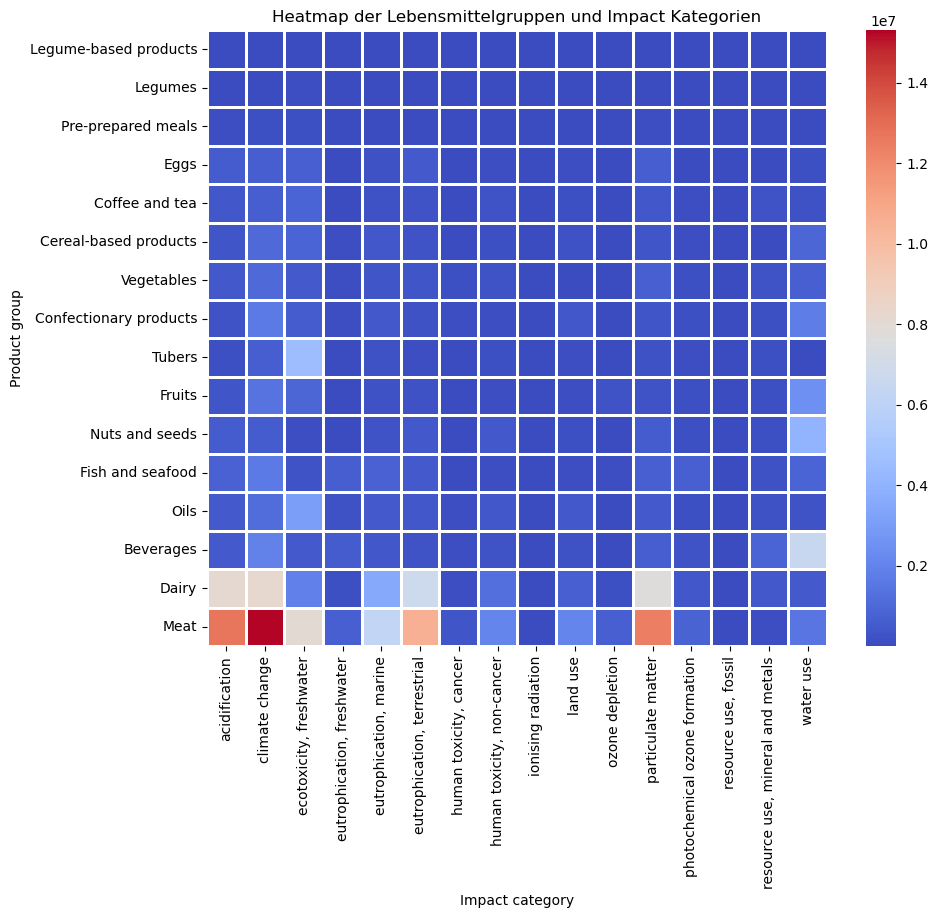

In [101]:
# Heatmap der Impact Kategorien & Lebensmittelgruppen
plt.figure(figsize=(10, 8))
sns.heatmap(weighted_product_group_impact_df, annot=False, cmap='coolwarm', linewidths=0.8)
plt.title('Heatmap der Lebensmittelgruppen und Impact Kategorien')
plt.show()

**Zwischenfazit:** Im Gesamtergebnis sind vor allem Fleisch- und Milchprodukte die schädlichsten Lebensmittelgruppen. Besonders in den Impact Kategorien Climate Change (Klimaerwärmung), Particulate Matter (Feinstaubbelastung) und Acidification (Versauerung) haben sie starken Einfluss auf die Werte. Auch Getränke schneiden schlecht ab, vor allem im EU-weiten Wasserverbrauch. Auch Nüsse, Kerne und Obst verbrauchen EU-weit viel Wasser. Besonders umweltschonend sind dagegen Hülsenfrüchte und Lebensmittel, die auf Hülsenfrucht-Basis hergestellt werden, sowie Fertiggerichte. Bei den Fertiggerichten muss man allerdings vorsichtig sein, da viele davon auf Fleisch basieren und sie somit stark mit der schädlichsten Lebensmittelgruppe verknüpft sind.

### Betrachtung der Produkte

Nachdem nun die schädlichen Produktgruppen identifiziert wurden, schaue ich mir im nächsten Schritt die dazugehörigen Produkte an.
**Welche sind die fünf schädlichsten und welche die fünf harmlosesten Lebensmittel?**

Hier nehme ich wieder den score_df hinzu, der mir den EU-weiten Single Weighted Score aller Produkte ausgibt.

In [106]:
score_df

Product group   Product  Year        Impact category  \
420        Beverages      Beer  2010  single weighted score   
896        Beverages      Beer  2011  single weighted score   
1372       Beverages      Beer  2012  single weighted score   
1848       Beverages      Beer  2013  single weighted score   
2324       Beverages      Beer  2014  single weighted score   
...              ...       ...   ...                    ...   
282688    Vegetables  Tomatoes  2018  single weighted score   
283164    Vegetables  Tomatoes  2019  single weighted score   
283640    Vegetables  Tomatoes  2020  single weighted score   
284116    Vegetables  Tomatoes  2021  single weighted score   
284592    Vegetables  Tomatoes  2022  single weighted score   

        Single weighted score        Unit  
420                  0.003964  billion pt  
896                  0.004019  billion pt  
1372                 0.004076  billion pt  
1848                 0.003833  billion pt  
2324                 0.003924  billion pt  
...                       ...         ...  
282688               0.003648  billion pt  
283164               0.003394  billion pt  
283640               0.003245  billion pt  
284116               0.004061  billion pt  
284592               0.003683  billion pt  

[598 rows x 6 columns]

Nun gruppiere ich diese Tabelle nach den Produkten und berechne die durchschnittlichen Scores über die Jahre. Dann suche ich mir die 5 höchsten und die 5 niedrigsten Werte raus.

In [108]:
# Relevante Spalten herausfiltern, nach Produkten gruppieren und nach höchsten Single Weighted Score (Jahresschnitt) sortieren
product_score_df = score_df[['Product', 'Single weighted score']].groupby(['Product']).mean().reset_index().sort_values(by='Single weighted score', ascending=False)

In [109]:
# Die 5 schädlichsten Produkte
product_score_df.head(5)

Product  Single weighted score
27            Pig meat               0.032096
5   Beef meat (cattle)               0.023396
14              Cheese               0.022223
29        Poultry meat               0.012818
11              Butter               0.009978

In [110]:
# Die 5 unschädlichsten Produkte
product_score_df.tail(5)

Product  Single weighted score
20       Lentils               0.000114
42          Tofu               0.000049
36  Soy beverage               0.000040
15     Chickpeas               0.000033
31        Quinoa               0.000005

Schweinefleisch, Rindfleisch, Käse, Geflügelfleisch und Butter gehören zu den schädlichsten Produkten in der EU. Linsen, Tofu, Sojadrinks, Kichererbsen und Quinoa sind die am wenigsten schädlichen Produkte.

#### Schädliche Lebensmittelgruppen & zugehörige Lebensmittel

Es wäre spannend zu sehen, wie sich der Anteil der Produkte je Produktgruppe am Single Weighted Score oder den anderen Impact Kategorien verhält. **Welche Lebensmittel tragen je Lebensmittelgruppe besonders zum Umweltschaden bei?**

Hierfür nehme ich wieder den score_df und gruppiere diesmal nach Lebensmittelgruppen, sowie nach Lebensmittelgruppen & Lebensmitteln zusammen, um das Ganze gemeinsam grafisch darzustellen.

In [115]:
# Relevante Spalten herausfiltern, nach Lebensmittelgruppen gruppieren und nach höchstem Single Weighted Score sortieren (Jahresschnitt)
group_score_df = score_df[['Product group', 'Single weighted score']].groupby(['Product group']).mean().reset_index().sort_values(by='Single weighted score', ascending=False)
group_score_df

Product group  Single weighted score
10                    Meat               0.018997
4                    Dairy               0.013780
14                  Tubers               0.006813
0                Beverages               0.004770
11          Nuts and seeds               0.003862
5                     Eggs               0.003769
3   Confectionary products               0.002190
2           Coffee and tea               0.002108
6         Fish and seafood               0.002051
15              Vegetables               0.001851
12                    Oils               0.001663
7                   Fruits               0.001428
1    Cereal-based products               0.001297
13      Pre-prepared meals               0.000756
9                  Legumes               0.000180
8    Legume-based products               0.000045

In [116]:
# Das gleiche nochmal mit Lebensmittelgruppen und Produkten zusammen
group_product_score_df = score_df[['Product group', 'Product', 'Single weighted score']].groupby(['Product group', 'Product']).sum().reset_index().sort_values(by='Single weighted score', ascending=False)
group_product_score_df = group_product_score_df.sort_values('Product group')
group_product_score_df

Product group             Product  Single weighted score
1                Beverages       Mineral water               0.018182
2                Beverages                Wine               0.115993
0                Beverages                Beer               0.051857
5    Cereal-based products              Quinoa               0.000063
6    Cereal-based products                Rice               0.027990
3    Cereal-based products               Bread               0.028821
4    Cereal-based products               Pasta               0.010576
8           Coffee and tea                 Tea               0.004374
7           Coffee and tea              Coffee               0.050443
11  Confectionary products               Sugar               0.018768
10  Confectionary products           Chocolate               0.059095
9   Confectionary products            Biscuits               0.007544
14                   Dairy                Milk               0.118809
12                   Dairy              Butter               0.129709
13                   Dairy              Cheese               0.288893
15                    Eggs                Eggs               0.048995
17        Fish and seafood              Salmon               0.022102
16        Fish and seafood                 Cod               0.036953
19        Fish and seafood       Tuna (canned)               0.032048
18        Fish and seafood              Shrimp               0.015533
24                  Fruits          Strawberry               0.014895
21                  Fruits             Avocado               0.002484
22                  Fruits             Bananas               0.023517
20                  Fruits              Apples               0.024642
23                  Fruits             Oranges               0.027314
25   Legume-based products        Soy beverage               0.000522
26   Legume-based products                Tofu               0.000639
29                 Legumes             Lentils               0.001478
27                 Legumes               Beans               0.005102
28                 Legumes           Chickpeas               0.000424
32                    Meat            Pig meat               0.417246
30                    Meat  Beef meat (cattle)               0.304152
33                    Meat        Poultry meat               0.166635
31                    Meat   Beef meat (dairy)               0.099789
35          Nuts and seeds              Cashew               0.033114
34          Nuts and seeds             Almonds               0.067299
38                    Oils        Rapeseed oil               0.006896
36                    Oils           Olive oil               0.023014
37                    Oils            Palm oil               0.009412
40                    Oils       Sunflower oil               0.061190
39                    Oils         Soybean oil               0.007603
41      Pre-prepared meals  Pre-prepared meals               0.009826
42                  Tubers            Potatoes               0.088570
45              Vegetables            Tomatoes               0.045133
43              Vegetables            Broccoli               0.020162
44              Vegetables              Carrot               0.006900

Ich erstelle dann einen Datenframe, der mir die Lebensmittelgruppen und Lebensmittel ausgibt und die jeweiligen Werte der Kombinationen.

In [118]:
# Pivotieren der Daten, um die Produktgruppen in Zeilen und die Produkte in Spalten zu bringen
group_product_score_df = group_product_score_df.pivot_table(index='Product group', columns='Product', values='Single weighted score', fill_value=0)
group_product_score_df

Product                  Almonds    Apples   Avocado   Bananas     Beans  \
Product group                                                              
Beverages               0.000000  0.000000  0.000000  0.000000  0.000000   
Cereal-based products   0.000000  0.000000  0.000000  0.000000  0.000000   
Coffee and tea          0.000000  0.000000  0.000000  0.000000  0.000000   
Confectionary products  0.000000  0.000000  0.000000  0.000000  0.000000   
Dairy                   0.000000  0.000000  0.000000  0.000000  0.000000   
Eggs                    0.000000  0.000000  0.000000  0.000000  0.000000   
Fish and seafood        0.000000  0.000000  0.000000  0.000000  0.000000   
Fruits                  0.000000  0.024642  0.002484  0.023517  0.000000   
Legume-based products   0.000000  0.000000  0.000000  0.000000  0.000000   
Legumes                 0.000000  0.000000  0.000000  0.000000  0.005102   
Meat                    0.000000  0.000000  0.000000  0.000000  0.000000   
Nuts and seeds          0.067299  0.000000  0.000000  0.000000  0.000000   
Oils                    0.000000  0.000000  0.000000  0.000000  0.000000   
Pre-prepared meals      0.000000  0.000000  0.000000  0.000000  0.000000   
Tubers                  0.000000  0.000000  0.000000  0.000000  0.000000   
Vegetables              0.000000  0.000000  0.000000  0.000000  0.000000   

Product                 Beef meat (cattle)  Beef meat (dairy)      Beer  \
Product group                                                             
Beverages                         0.000000           0.000000  0.051857   
Cereal-based products             0.000000           0.000000  0.000000   
Coffee and tea                    0.000000           0.000000  0.000000   
Confectionary products            0.000000           0.000000  0.000000   
Dairy                             0.000000           0.000000  0.000000   
Eggs                              0.000000           0.000000  0.000000   
Fish and seafood                  0.000000           0.000000  0.000000   
Fruits                            0.000000           0.000000  0.000000   
Legume-based products             0.000000           0.000000  0.000000   
Legumes                           0.000000           0.000000  0.000000   
Meat                              0.304152           0.099789  0.000000   
Nuts and seeds                    0.000000           0.000000  0.000000   
Oils                              0.000000           0.000000  0.000000   
Pre-prepared meals                0.000000           0.000000  0.000000   
Tubers                            0.000000           0.000000  0.000000   
Vegetables                        0.000000           0.000000  0.000000   

Product                 Biscuits     Bread  ...  Soy beverage  Soybean oil  \
Product group                               ...                              
Beverages               0.000000  0.000000  ...      0.000000     0.000000   
Cereal-based products   0.000000  0.028821  ...      0.000000     0.000000   
Coffee and tea          0.000000  0.000000  ...      0.000000     0.000000   
Confectionary products  0.007544  0.000000  ...      0.000000     0.000000   
Dairy                   0.000000  0.000000  ...      0.000000     0.000000   
Eggs                    0.000000  0.000000  ...      0.000000     0.000000   
Fish and seafood        0.000000  0.000000  ...      0.000000     0.000000   
Fruits                  0.000000  0.000000  ...      0.000000     0.000000   
Legume-based products   0.000000  0.000000  ...      0.000522     0.000000   
Legumes                 0.000000  0.000000  ...      0.000000     0.000000   
Meat                    0.000000  0.000000  ...      0.000000     0.000000   
Nuts and seeds          0.000000  0.000000  ...      0.000000     0.000000   
Oils                    0.000000  0.000000  ...      0.000000     0.007603   
Pre-prepared meals      0.000000  0.000000  ...      0.000000     0.000000   
Tubers                  0.000000

Da die Grafik etwas komplexer ist und um sie lesbarer und nachvollziehbarer zu machen, habe ich Plotly genutzt.

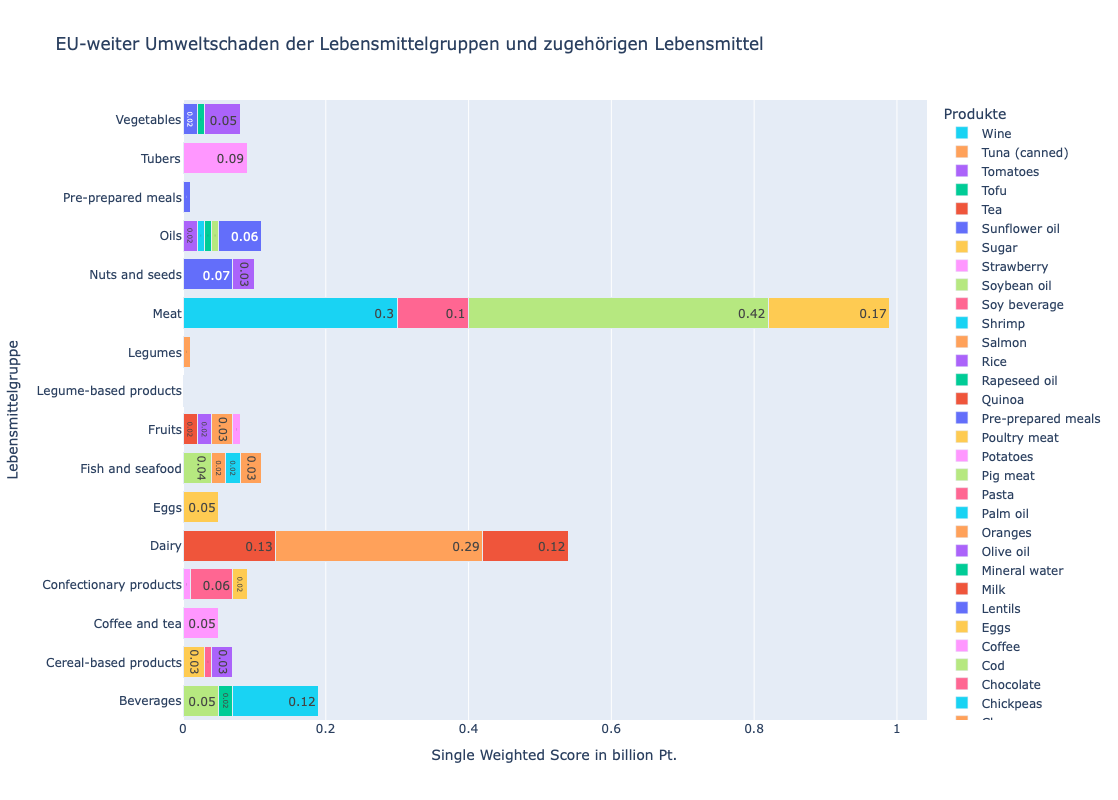

In [120]:
# Import von Plotly
import plotly.graph_objects as go

# Erstellen eines gestapelten Balkendiagramms mit den Lebensmittelgruppen und Anteilen der zugehörigen Lebensmittel
fig = go.Figure()

for product in group_product_score_df.columns:
    fig.add_trace(go.Bar(
        x=group_product_score_df[product].round(2),  # X-Achse: Single Weighted Scores 
        y=group_product_score_df.index,  # Y-Achse: Lebensmittelgruppen
        name=product,
        orientation='h',  
        hoverinfo='x+name',  # Zeige den Wert und den Namen des Produkts beim Hover an
        text=group_product_score_df[product].round(2),  # Zeige die Werte direkt auf den Balken an
        textposition='inside'  
    ))

fig.update_layout(
    title='EU-weiter Umweltschaden der Lebensmittelgruppen und zugehörigen Lebensmittel',
    xaxis_title='Single Weighted Score in billion Pt.',
    yaxis_title='Lebensmittelgruppe',
    barmode='stack',  
    legend_title='Produkte',
    width=1100,
    height=800
)

fig.show()

Hier sehen wir nochmal übersichtlich, wie schädlich die Lebensmittelgruppen sind und wie viel die jeweiligen Produkte dazu beitragen.

**Zwischenfazit:**  Bei den Fleischprodukten sind vor allem Schweinefleisch und Rindfleisch am schädlichsten. Bei Milchprodukten ist es Käse und bei Getränken ist es Wein. Insgesamt gehören Schweinefleisch, Rindfleisch, Käse, Geflügelfleisch und Butter zu den schädlichsten Lebensmitteln und Linsen, Tofu, Sojadrinks, Kichererbsen und Quinoa zu den harmlosesten Lebensmitteln.

### Betrachtung der Länder

Nachdem ich nun die Produktgruppen und Produkte besonders unter die Lupe genommen habe, wird es im zweiten Teil der Analyse um die Länder gehen.
**Welche Länder sind besonders schädlich und welche nicht? Und in welchen Impact Kategorien haben sie besonders hohe Werte?**

In [125]:
# Aufrufen der Ländertabelle
country_df

Country Product group   Product  Year Impact category  \
1        Austria     Beverages      Beer  2010   acidification   
2        Belgium     Beverages      Beer  2010   acidification   
3       Bulgaria     Beverages      Beer  2010   acidification   
4        Croatia     Beverages      Beer  2010   acidification   
5         Cyprus     Beverages      Beer  2010   acidification   
...          ...           ...       ...   ...             ...   
284643   Romania    Vegetables  Tomatoes  2022       water use   
284644  Slovakia    Vegetables  Tomatoes  2022       water use   
284645  Slovenia    Vegetables  Tomatoes  2022       water use   
284646     Spain    Vegetables  Tomatoes  2022       water use   
284647    Sweden    Vegetables  Tomatoes  2022       water use   

        Characterized results                   Unit  
1                    5.935072     million mol H⁺ eq.  
2                    6.510698     million mol H⁺ eq.  
3                    3.542002     million mol H⁺ eq.  
4                    2.321899     million mol H⁺ eq.  
5                    0.554170     million mol H⁺ eq.  
...                       ...                    ...  
284643               0.002946  trillion m³ water eq.  
284644               0.000400  trillion m³ water eq.  
284645               0.000272  trillion m³ water eq.  
284646               0.009805  trillion m³ water eq.  
284647               0.001365  trillion m³ water eq.  

[274482 rows x 7 columns]

Ich möchte analysieren, welche Länder in welchen Impact Kategorien besonders hoch sind. Dazu muss ich erstmal die Tabelle etwas umstellen. Ich gruppiere nach Ländern und Impact Kategorien und berechne die Summe der Werte über alle Produkte und Jahre.

In [127]:
# Impact der Länder je Impact Kategorie in Summe über die Produkte & Jahre
country_impact_df = country_df[['Country', 'Impact category', 'Characterized results']].groupby(['Country', 'Impact category']).sum().reset_index()
country_impact_df

Country                   Impact category  Characterized results
0    Austria                     acidification            5617.002718
1    Austria                    climate change             311.532021
2    Austria           ecotoxicity, freshwater           17321.085991
3    Austria        eutrophication, freshwater              38.427280
4    Austria            eutrophication, marine            2141.960311
..       ...                               ...                    ...
454   Sweden     photochemical ozone formation             974.273326
455   Sweden              resource use, fossil            2565.313758
456   Sweden  resource use, mineral and metals               0.923468
457   Sweden             single weighted score              70.259806
458   Sweden                         water use               1.130599

[459 rows x 3 columns]

Dann erstelle ich eine Pivot-Tabelle, die mir die Länder und Impact Kategorien ausgibt mit dem jeweiligen Ergebniswert.

In [129]:
# Pivot-Tabelle der Impact Kategorien und Länder
country_impact_df = country_impact_df.pivot(index='Country', columns=['Impact category'], values='Characterized results')
country_impact_df

Impact category  acidification  climate change  ecotoxicity, freshwater  \
Country                                                                   
Austria            5617.002718      311.532021             17321.085991   
Belgium            7781.615731      496.305174             33798.955778   
Bulgaria           2381.287797      157.235947             10218.857085   
Croatia            2175.691292      124.345409              7102.929203   
Cyprus              629.774985       36.261238              1872.686002   
Czechia            5455.622888      328.016193             18677.728484   
Denmark            5288.925786      273.656331             16751.508365   
Estonia             686.310283       42.266617              2410.685600   
Finland            4510.583148      221.169214              9740.771889   
France            53004.775158     2754.769843            118587.799252   
Germany           65619.205669     3575.980211            171880.840422   
Greece             5989.507297      335.120766             16692.149558   
Hungary            3655.240560      239.252750             15358.609468   
Ireland            5990.741863      277.752218             11488.287472   
Italy             49973.309616     2619.738762            111309.476072   
Latvia             1147.610569       70.532153              4741.355707   
Lithuania          1701.702463      101.435326              6311.397865   
Luxembourg          597.556701       32.217206              1382.902161   
Malta               476.187508       26.469190              1165.770288   
Netherlands       15515.423881      866.897873             48658.986847   
Poland            19867.674150     1226.866303             76748.718787   
Portugal           6366.137947      398.135465             19271.114711   
Romania            6931.758971      470.518373             39513.661427   
Slovakia           2265.789891      138.231860              8433.404911   
Slovenia           1116.337171       67.246986              3647.153250   
Spain             36580.883571     2132.870637            114361.372359   
Sweden             8500.101630      444.261448             20913.017982   

Impact category  eutrophication, freshwater  eutrophication, marine  \
Country                                                               
Austria                           38.427280             2141.960311   
Belgium                           67.558902             3198.135905   
Bulgaria                          22.230279              941.964345   
Croatia                           16.473125              889.035694   
Cyprus                             4.623607              251.236120   
Czechia                           45.725194             2152.281297   
Denmark                           30.773084             2111.661093   
Estonia                            6.678701              279.827889   
Finland                           24.696585             1751.413585   
France                           329.413738            20692.991695   
Germany                          376.791798            24873.938844   
Greece                            37.060956             2310.228217   
Hungary                           32.863442             1400.402442   
Ireland                           23.764349             2371.128571   
Italy                            288.990584            19279.368030   
Latvia                             9.447852              455.103632   
Lithuania                         15.078826              676.331580   
Luxembourg                         3.821746              231.028917   
Malta                              3.588802              192.862792   
Netherlands                      102.561463             6119.150735   
Poland                           154.222528             7446.771190   
Portugal                          63.847033             2611.545442   
Romania                           73.632332             2919.218474   
Slovakia                          19.124372      

Nun betrachte ich die zehn Länder mit dem höchsten Single Weighted Score.

In [131]:
# Sortieren nach den Ländern mit dem höchsten Score -> 10 Länder herausfiltern
country_impact_sorted = country_impact_df.sort_values(by='single weighted score', ascending=False)
country_impact_sorted.head(10)

Impact category  acidification  climate change  ecotoxicity, freshwater  \
Country                                                                   
Germany           65619.205669     3575.980211            171880.840422   
France            53004.775158     2754.769843            118587.799252   
Italy             49973.309616     2619.738762            111309.476072   
Spain             36580.883571     2132.870637            114361.372359   
Poland            19867.674150     1226.866303             76748.718787   
Netherlands       15515.423881      866.897873             48658.986847   
Belgium            7781.615731      496.305174             33798.955778   
Romania            6931.758971      470.518373             39513.661427   
Sweden             8500.101630      444.261448             20913.017982   
Portugal           6366.137947      398.135465             19271.114711   

Impact category  eutrophication, freshwater  eutrophication, marine  \
Country                                                               
Germany                          376.791798            24873.938844   
France                           329.413738            20692.991695   
Italy                            288.990584            19279.368030   
Spain                            331.307522            14269.387474   
Poland                           154.222528             7446.771190   
Netherlands                      102.561463             6119.150735   
Belgium                           67.558902             3198.135905   
Romania                           73.632332             2919.218474   
Sweden                            52.905101             3375.601155   
Portugal                          63.847033             2611.545442   

Impact category  eutrophication, terrestrial  human toxicity, cancer  \
Country                                                                
Germany                           283.377399                2.845613   
France                            228.396395                1.878533   
Italy                             214.593499                1.954146   
Spain                             154.293189                1.714488   
Poland                             85.426600                0.973368   
Netherlands                        66.998768                0.643932   
Belgium                            33.167139                0.416631   
Romania                            29.351535                0.526711   
Sweden                             36.625592                0.339130   
Portugal                           27.127088                0.303902   

Impact category  human toxicity, non-cancer  ionising radiation    land use  \
Country                                                                       
Germany                           99.960508        60046.420479  138.666921   
France                            70.119693        43491.384895   98.634650   
Italy                             70.418420        44037.576219  100.738190   
Spain                             55.844317        39171.605434   87.217953   
Poland                            29.872715        21927.157285   44.617791   
Netherlands                       23.049896        14159.129664   33.443586   
Belgium                           13.737983         9334.361418   20.345561   
Romania                           13.809463        10059.396468   19.873965   
Sweden                            12.472592         7488.159695   16.870486   
Portugal                           9.583142         7336.568971   14.258098   

Impact category  ozone depletion  particulate matter  \
Country                                                
Germany              2696.270940          476.730936   
France               2090.915014          384.978821   
Italy                2036.390133          364.542909   
Spain                1779.125636          270.415276   
Poland               1206.125740          146.200330   
Netherlands           667.658994        

Schauen wir uns diese 10 Länder nun mal im Zeitverlauf an.

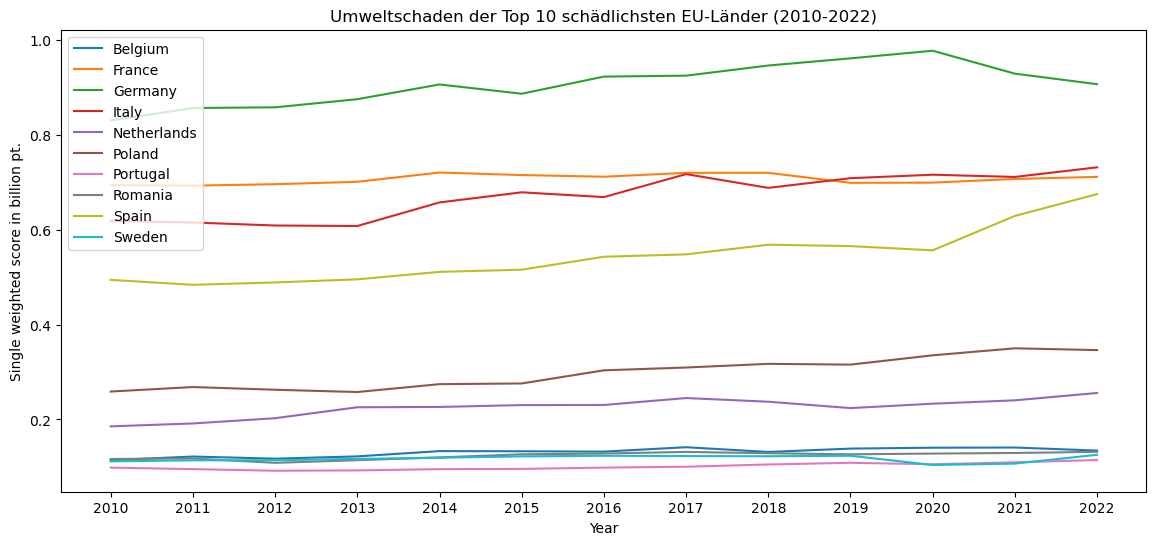

In [133]:
# Grafische Darstellung
# Impact der Top 10 EU Länder - Single weighted Score
years = sorted(country_df['Year'].unique())  # Einzigartige Jahre sortiert abrufen
top_10_countries =['Germany', 'France', 'Italy', 'Spain', 'Poland', 'Netherlands', 'Belgium', 'Romania', 'Sweden', 'Portugal']
plt.figure(figsize=(14,6))
sns.lineplot(x='Year', y='Characterized results', hue='Country', palette='tab10', errorbar=None, data=country_df[(country_df['Impact category'] == 'single weighted score') & (country_df['Country'].isin(top_10_countries))])
plt.ylabel('Single weighted score in billion pt.')
plt.title('Umweltschaden der Top 10 schädlichsten EU-Länder (2010-2022)')
plt.xticks(ticks=years, labels=years)
plt.legend(loc='upper left')
plt.show()

Mit Abstand ganz oben liegt hier Deutschland mit einem Score von über 0,8. Danach folgen Frankreich und Italien, wobei Italien seit ca. 2019 den 2. Platz übernommen hat. Spanien liegt bei ca. 0,5 an 4. Stelle und alle anderen Top 10-Länder (Polen, Niederlande, Belgien, Rumänien, Schweden und Portugal) liegen bei einem Score von unter 0,3.

In Power BI habe ich alle Länder anschaulich in einer Kartenansicht dargestellt, mit einer Filtermöglichkeit für die Lebensmittelgruppen.

#### Betrachtung der Pro-Kopf Daten

Die bisherigen Daten beziehen sich auf die Werte pro Land. Spannend wäre aber auch zu wissen, wie sich das Ganze pro Kopf verhält. Deshalb habe ich beschlossen, die aktuellen demografischen Daten hinzuzuziehen, um Pro Kopf-Werte berechnen zu können.

In [138]:
# Demografische Daten der EU von Wikipedia abrufen
demographics_table = pd.read_html('https://en.wikipedia.org/wiki/Demographics_of_the_European_Union', match='Member State')
demographics_table

[      Member State  Population % pop.  Area km2 % area  Density /km2
 0   European Union   449206579   100%   4225134   100%           106
 1          Austria     9158750   2.0%     83878   2.0%           109
 2          Belgium    11832049   2.6%     30667   0.7%           383
 3         Bulgaria     6445481   1.4%    110996   2.6%            58
 4          Croatia     3861967   0.9%     56594   1.3%            68
 5           Cyprus      933505   0.2%      9253   0.2%           100
 6   Czech Republic    10900555   2.4%     78871   1.9%           137
 7          Denmark     5961249   1.3%     42925   1.0%           138
 8          Estonia     1374687   0.3%     45336   1.1%            30
 9          Finland     5603851   1.2%    338411   8.0%            16
 10          France    68401977  15.2%    638475  15.1%           107
 11         Germany    83445000  18.6%    357569   8.5%           236
 12          Greece    10397193   2.3%    131694   3.1%            79
 13         Hungary 

In [139]:
# In einen Datenframe schreiben (nur Land + Anwohnerzahl)
demographics_df = demographics_table[0]
demographics_df = demographics_df[['Member State', 'Population']]
demographics_df

Member State  Population
0   European Union   449206579
1          Austria     9158750
2          Belgium    11832049
3         Bulgaria     6445481
4          Croatia     3861967
5           Cyprus      933505
6   Czech Republic    10900555
7          Denmark     5961249
8          Estonia     1374687
9          Finland     5603851
10          France    68401977
11         Germany    83445000
12          Greece    10397193
13         Hungary     9584627
14         Ireland     5343805
15           Italy    58989749
16          Latvia     1871882
17       Lithuania     2885891
18      Luxembourg      672050
19           Malta      563443
20     Netherlands    17942942
21          Poland    36620970
22        Portugal    10639726
23         Romania    19064409
24        Slovakia     5424687
25        Slovenia     2123949
26           Spain    48610458
27          Sweden    10551707

In [140]:
# Name für EU umbenennen, damit es mit dem food_df matcht
demographics_df.at[0, 'Member State'] = 'European Union 27'

# Länderspalte umbenennen, damit es mit dem food_df matcht
demographics_df = demographics_df.rename(columns={'Member State': 'Country'})

Ich merge die beiden Datenframes food_df & demographics_df, um dann Berechnungen vornehmen zu können.

In [142]:
# Mergen von food_df und demographics_df
food_demo_df = pd.merge(food_df, demographics_df, on='Country')
food_demo_df

Country Product group   Product  Year Impact category  \
0       European Union 27     Beverages      Beer  2010   acidification   
1                 Austria     Beverages      Beer  2010   acidification   
2                 Belgium     Beverages      Beer  2010   acidification   
3                Bulgaria     Beverages      Beer  2010   acidification   
4                 Croatia     Beverages      Beer  2010   acidification   
...                   ...           ...       ...   ...             ...   
274477            Romania    Vegetables  Tomatoes  2022       water use   
274478           Slovakia    Vegetables  Tomatoes  2022       water use   
274479           Slovenia    Vegetables  Tomatoes  2022       water use   
274480              Spain    Vegetables  Tomatoes  2022       water use   
274481             Sweden    Vegetables  Tomatoes  2022       water use   

        Characterized results                   Unit  Population  
0                    0.210668     billion mol H⁺ eq.   449206579  
1                    5.935072     million mol H⁺ eq.     9158750  
2                    6.510698     million mol H⁺ eq.    11832049  
3                    3.542002     million mol H⁺ eq.     6445481  
4                    2.321899     million mol H⁺ eq.     3861967  
...                       ...                    ...         ...  
274477               0.002946  trillion m³ water eq.    19064409  
274478               0.000400  trillion m³ water eq.     5424687  
274479               0.000272  trillion m³ water eq.     2123949  
274480               0.009805  trillion m³ water eq.    48610458  
274481               0.001365  trillion m³ water eq.    10551707  

[274482 rows x 8 columns]

Nun kann ich die Pro-Kopf Werte berechnen.

In [144]:
# Pro Kopf-Werte berechnen und als neue Spalte hinzufügen
food_demo_df['Per Capita'] = food_demo_df['Characterized results'] / food_demo_df['Population']
food_demo_df

Country Product group   Product  Year Impact category  \
0       European Union 27     Beverages      Beer  2010   acidification   
1                 Austria     Beverages      Beer  2010   acidification   
2                 Belgium     Beverages      Beer  2010   acidification   
3                Bulgaria     Beverages      Beer  2010   acidification   
4                 Croatia     Beverages      Beer  2010   acidification   
...                   ...           ...       ...   ...             ...   
274477            Romania    Vegetables  Tomatoes  2022       water use   
274478           Slovakia    Vegetables  Tomatoes  2022       water use   
274479           Slovenia    Vegetables  Tomatoes  2022       water use   
274480              Spain    Vegetables  Tomatoes  2022       water use   
274481             Sweden    Vegetables  Tomatoes  2022       water use   

        Characterized results                   Unit  Population    Per Capita  
0                    0.210668     billion mol H⁺ eq.   449206579  4.689785e-10  
1                    5.935072     million mol H⁺ eq.     9158750  6.480220e-07  
2                    6.510698     million mol H⁺ eq.    11832049  5.502595e-07  
3                    3.542002     million mol H⁺ eq.     6445481  5.495326e-07  
4                    2.321899     million mol H⁺ eq.     3861967  6.012219e-07  
...                       ...                    ...         ...           ...  
274477               0.002946  trillion m³ water eq.    19064409  1.545276e-10  
274478               0.000400  trillion m³ water eq.     5424687  7.366231e-11  
274479               0.000272  trillion m³ water eq.     2123949  1.278683e-10  
274480               0.009805  trillion m³ water eq.    48610458  2.017059e-10  
274481               0.001365  trillion m³ water eq.    10551707  1.293817e-10  

[274482 rows x 9 columns]

Ich trenne auch hier wieder die EU-Daten und die Länderdaten.

In [146]:
# Jeweils eine EU-Tabelle und eine Ländertabelle erstellen
capita_eu_df = food_demo_df[food_demo_df['Country'] == 'European Union 27']
capita_country_df = food_demo_df[food_demo_df['Country'] != 'European Union 27']

Für die Nachvollziehbarkeit und den späteren Vergleich zu den weltweiten Grenzwerten werde ich die Einheiten der Pro-Kopf Werte anpassen.

In [148]:
# Einheiten der Länder-Tabelle
capita_country_df[['Impact category', 'Unit']].groupby('Impact category').value_counts()

Impact category                   Unit                     
acidification                     million mol H⁺ eq.           15548
climate change                    million tonnes CO₂ eq.       15548
ecotoxicity, freshwater           billion CTUe                 15548
eutrophication, freshwater        thousand tonnes P eq.        15548
eutrophication, marine            thousand tonnes N eq.        15548
eutrophication, terrestrial       billion mol N eq.            15548
human toxicity, cancer            thousand CTUh                15548
human toxicity, non-cancer        thousand CTUh                15548
ionising radiation                thousand tonnes U-235 eq.    15548
land use                          trillion Pt.                 15548
ozone depletion                   tonnes CFC-11 eq             15548
particulate matter                disease incidence (x1000)    15548
photochemical ozone formation     thousand tonnes NMVOC eq.    15548
resource use, fossil              petajoule

In [149]:
# Acidification, Climate Change, Single weighted score -> Millionen
capita_country_df.loc[capita_country_df['Impact category'].isin(['acidification', 'climate change', 'single weighted score']), ['Per Capita']] *= 1000000
capita_country_df.loc[
    capita_country_df['Impact category'].isin(['acidification', 'climate change', 'single weighted score']),
    'Unit'
] = capita_country_df.loc[
    capita_country_df['Impact category'].isin(['acidification', 'climate change', 'single weighted score']),
    'Unit'
].str.replace('million ', '', regex=False)

In [150]:
# Ecotoxicity, freshwater, Eutrophication, terrestrial & Resource use, fossil -> Billion (Milliarden)
capita_country_df.loc[capita_country_df['Impact category'].isin(['ecotoxicity, freshwater', 'eutrophication, terrestrial', 'resource use, fossil']), ['Per Capita']] *= 1000000000
capita_country_df.loc[
    capita_country_df['Impact category'].isin(['ecotoxicity, freshwater', 'eutrophication, terrestrial']),
    'Unit'
] = capita_country_df.loc[
    capita_country_df['Impact category'].isin(['ecotoxicity, freshwater', 'eutrophication, terrestrial']),
    'Unit'
].str.replace('billion ', '', regex=False)
capita_country_df.loc[
    capita_country_df['Impact category'] == 'resource use, fossil',
    'Unit'
] = capita_country_df.loc[
    capita_country_df['Impact category'] == 'resource use, fossil',
    'Unit'
].str.replace('petajoule (PJ)', 'megajoule (MJ)', regex=False)

In [151]:
# Eutrophication, freshwater, Eutrophication, marine, Human toxicity, cancer, Human toxicity, non-cancer, 
# Ionising radiation, Particulate matter, Photochemical ozone formation, Resource use, mineral and metals -> Tausend
capita_country_df.loc[capita_country_df['Impact category'].isin(['eutrophication, freshwater', 'eutrophication, marine', 'human toxicity, cancer', 'human toxicity, non-cancer', 'ionising radiation', 'particulate matter', 'photochemical ozone formation', 'resource use, mineral and metals']), ['Per Capita']] *= 1000
capita_country_df.loc[
    capita_country_df['Impact category'].isin(['eutrophication, freshwater', 'eutrophication, marine', 'human toxicity, cancer', 'human toxicity, non-cancer', 'ionising radiation', 'photochemical ozone formation', 'resource use, mineral and metals']),
    'Unit'
] = capita_country_df.loc[
    capita_country_df['Impact category'].isin(['eutrophication, freshwater', 'eutrophication, marine', 'human toxicity, cancer', 'human toxicity, non-cancer', 'ionising radiation', 'photochemical ozone formation', 'resource use, mineral and metals']),
    'Unit'
].str.replace('thousand ', '', regex=False)
capita_country_df.loc[
    capita_country_df['Impact category'] == 'particulate matter',
    'Unit'
] = capita_country_df.loc[
    capita_country_df['Impact category'] == 'particulate matter',
    'Unit'
].str.replace('(x1000)', '', regex=False)

In [152]:
# Land use & Water use -> Trillion (Billionen)
capita_country_df.loc[capita_country_df['Impact category'].isin(['land use', 'water use']), ['Per Capita']] *= 1000000000000
capita_country_df.loc[
    capita_country_df['Impact category'].isin(['land use', 'water use']),
    'Unit'
] = capita_country_df.loc[
    capita_country_df['Impact category'].isin(['land use', 'water use']),
    'Unit'
].str.replace('trillion ', '', regex=False)

In [153]:
# Tonnes in kg
capita_country_df.loc[capita_country_df['Impact category'].isin(['climate change', 'eutrophication, freshwater', 'eutrophication, marine', 'ionising radiation', 'ozone depletion', 'photochemical ozone formation', 'resource use, mineral and metals']), ['Per Capita']] *= 1000
capita_country_df.loc[
    capita_country_df['Impact category'].isin(['climate change', 'eutrophication, freshwater', 'eutrophication, marine', 'ionising radiation', 'ozone depletion', 'photochemical ozone formation', 'resource use, mineral and metals']),
    'Unit'
] = capita_country_df.loc[
    capita_country_df['Impact category'].isin(['climate change', 'eutrophication, freshwater', 'eutrophication, marine', 'ionising radiation', 'ozone depletion', 'photochemical ozone formation', 'resource use, mineral and metals']),
    'Unit'
].str.replace('tonnes ', 'kg ', regex=False)

In [154]:
# Prüfen der Einheiten
capita_country_df[['Impact category', 'Unit']].groupby('Impact category').value_counts()

Impact category                   Unit              
acidification                     mol H⁺ eq.            15548
climate change                    kg CO₂ eq.            15548
ecotoxicity, freshwater           CTUe                  15548
eutrophication, freshwater        kg P eq.              15548
eutrophication, marine            kg N eq.              15548
eutrophication, terrestrial       mol N eq.             15548
human toxicity, cancer            CTUh                  15548
human toxicity, non-cancer        CTUh                  15548
ionising radiation                kg U-235 eq.          15548
land use                          Pt.                   15548
ozone depletion                   kg CFC-11 eq          15548
particulate matter                disease incidence     15548
photochemical ozone formation     kg NMVOC eq.          15548
resource use, fossil              megajoule (MJ)        15548
resource use, mineral and metals  kg Sb eq.             15548
single weighted s

Auch diesmal möchte ich wieder die 10 Ländern mit dem höchsten Single Weighted Score herausfiltern. Hierfür stelle ich die Tabelle wieder zu einem Impact-Dataframe um.

In [156]:
# Tabelle auf wichtige Spalten reduzieren
capita_country_df = capita_country_df[['Country', 'Product group', 'Product', 'Year', 'Impact category', 'Per Capita', 'Unit']]
capita_country_df

Country Product group   Product  Year Impact category  Per Capita  \
1        Austria     Beverages      Beer  2010   acidification    0.648022   
2        Belgium     Beverages      Beer  2010   acidification    0.550260   
3       Bulgaria     Beverages      Beer  2010   acidification    0.549533   
4        Croatia     Beverages      Beer  2010   acidification    0.601222   
5         Cyprus     Beverages      Beer  2010   acidification    0.593644   
...          ...           ...       ...   ...             ...         ...   
274477   Romania    Vegetables  Tomatoes  2022       water use  154.527612   
274478  Slovakia    Vegetables  Tomatoes  2022       water use   73.662310   
274479  Slovenia    Vegetables  Tomatoes  2022       water use  127.868306   
274480     Spain    Vegetables  Tomatoes  2022       water use  201.705877   
274481    Sweden    Vegetables  Tomatoes  2022       water use  129.381667   

                Unit  
1         mol H⁺ eq.  
2         mol H⁺ eq.  
3         mol H⁺ eq.  
4         mol H⁺ eq.  
5         mol H⁺ eq.  
...              ...  
274477  m³ water eq.  
274478  m³ water eq.  
274479  m³ water eq.  
274480  m³ water eq.  
274481  m³ water eq.  

[264316 rows x 7 columns]

In [157]:
# Impact der Länder je Impact Kategorie im Schnitt über die Produkte & Jahre
capita_country_impact_df = capita_country_df[['Country', 'Impact category', 'Per Capita']].groupby(['Country', 'Impact category']).mean().reset_index()
capita_country_impact_df

Country                   Impact category   Per Capita
0    Austria                     acidification     1.025575
1    Austria                    climate change    56.880749
2    Austria           ecotoxicity, freshwater  3162.552394
3    Austria        eutrophication, freshwater     0.007016
4    Austria            eutrophication, marine     0.391088
..       ...                               ...          ...
437   Sweden     photochemical ozone formation     0.154403
438   Sweden              resource use, fossil   406.552451
439   Sweden  resource use, mineral and metals     0.000146
440   Sweden             single weighted score     0.011135
441   Sweden                         water use   179.177992

[442 rows x 3 columns]

In [158]:
# Pro-Kopf Impacts pro Land und Kategorie 
capita_country_impact_df = capita_country_impact_df.pivot(index='Country', columns=['Impact category'], values='Per Capita')
capita_country_impact_df

Impact category  acidification  climate change  ecotoxicity, freshwater  \
Country                                                                   
Austria               1.025575       56.880749              3162.552394   
Belgium               1.099787       70.143537              4776.855889   
Bulgaria              0.617811       40.793909              2651.220254   
Croatia               0.942079       53.841855              3075.585066   
Cyprus                1.128152       64.956826              3354.649352   
Denmark               1.483642       76.765672              4699.108491   
Estonia               0.834864       51.415312              2932.483410   
Finland               1.346000       65.998933              2906.736136   
France                1.295821       67.346570              2899.146564   
Germany               1.315011       71.662772              3444.498227   
Greece                0.963327       53.899415              2684.695146   
Hungary               0.637734       41.742700              2679.634108   
Ireland               1.874687       86.917205              3595.038192   
Italy                 1.416643       74.264328              3155.399892   
Latvia                1.025215       63.009712              4235.677502   
Lithuania             0.986058       58.777096              3657.164124   
Luxembourg            1.486881       80.165058              3441.031797   
Malta                 1.413275       78.557829              3459.886167   
Netherlands           1.446002       80.792882              4534.905325   
Poland                0.907227       56.022981              3504.613316   
Portugal              1.000563       62.574766              3028.832165   
Romania               0.608021       41.271671              3465.953595   
Slovakia              0.698464       42.612036              2599.723044   
Slovenia              0.878922       52.945317              2871.499494   
Spain                 1.258413       73.372551              3934.127778   
Sweden                1.347101       70.406819              3314.307531   

Impact category  eutrophication, freshwater  eutrophication, marine  \
Country                                                               
Austria                            0.007016                0.391088   
Belgium                            0.009548                0.451997   
Bulgaria                           0.005768                0.244387   
Croatia                            0.007133                0.384955   
Cyprus                             0.008283                0.450054   
Denmark                            0.008632                0.592360   
Estonia                            0.008124                0.340397   
Finland                            0.007370                0.522638   
France                             0.008053                0.505887   
Germany                            0.007551                0.498475   
Greece                             0.005961                0.371567   
Hungary                            0.005734                0.244330   
Ireland                            0.007437                0.741999   
Italy                              0.008192                0.546531   
Latvia                             0.008440                0.406566   
Lithuania                          0.008737                0.391903   
Luxembourg                         0.009510                0.574862   
Malta                              0.010651                0.572397   
Netherlands                        0.009558                0.570291   
Poland                             0.007042                0.340045   
Portugal                           0.010035                0.410455   
Romania                            0.006459                0.256060   
Slovakia                           0.005895                0.274473   
Slovenia                           0.006487                0.358243   
Spain                              0.011397          

In [159]:
# Sortieren nach den Ländern mit dem höchsten Score -> 10 schlimmsten Länder herausfiltern
capita_country_impact_sorted = capita_country_impact_df.sort_values(by='single weighted score', ascending=False)
capita_country_impact_sorted.head(10)

Impact category  acidification  climate change  ecotoxicity, freshwater  \
Country                                                                   
Ireland               1.874687       86.917205              3595.038192   
Netherlands           1.446002       80.792882              4534.905325   
Denmark               1.483642       76.765672              4699.108491   
Luxembourg            1.486881       80.165058              3441.031797   
Malta                 1.413275       78.557829              3459.886167   
Italy                 1.416643       74.264328              3155.399892   
Spain                 1.258413       73.372551              3934.127778   
Sweden                1.347101       70.406819              3314.307531   
Belgium               1.099787       70.143537              4776.855889   
Germany               1.315011       71.662772              3444.498227   

Impact category  eutrophication, freshwater  eutrophication, marine  \
Country                                                               
Ireland                            0.007437                0.741999   
Netherlands                        0.009558                0.570291   
Denmark                            0.008632                0.592360   
Luxembourg                         0.009510                0.574862   
Malta                              0.010651                0.572397   
Italy                              0.008192                0.546531   
Spain                              0.011397                0.490879   
Sweden                             0.008384                0.534967   
Belgium                            0.009548                0.451997   
Germany                            0.007551                0.498475   

Impact category  eutrophication, terrestrial  human toxicity, cancer  \
Country                                                                
Ireland                             8.178333            5.497721e-08   
Netherlands                         6.244131            6.001296e-08   
Denmark                             6.428170            5.462426e-08   
Luxembourg                          6.421451            5.833351e-08   
Malta                               6.095809            5.793983e-08   
Italy                               6.083294            5.539611e-08   
Spain                               5.307816            5.897985e-08   
Sweden                              5.804446            5.374551e-08   
Belgium                             4.687560            5.888311e-08   
Germany                             5.678893            5.702619e-08   

Impact category  human toxicity, non-cancer  ionising radiation     land use  \
Country                                                                        
Ireland                            0.000002            1.239718  3113.744461   
Netherlands                        0.000002            1.319598  3116.865043   
Denmark                            0.000002            1.208280  2812.777529   
Luxembourg                         0.000002            1.275031  3015.188214   
Malta                              0.000002            1.271936  2902.794208   
Italy                              0.000002            1.248377  2855.725171   
Spain                              0.000002            1.347536  3000.371228   
Sweden                             0.000002            1.186728  2673.644623   
Belgium                            0.000002            1.319239  2875.467914   
Germany                            0.000002            1.203332  2778.890090   

Impact category  ozone depletion  particulate matter  \
Country                                                
Ireland                 0.000053            0.000013   
Netherlands             0.000062            0.000011   
Denmark                 0.000059            0.000011   
Luxembourg              0.000062            0.000011   
Malta                   0.000058            0.000010   
Italy                   0.00

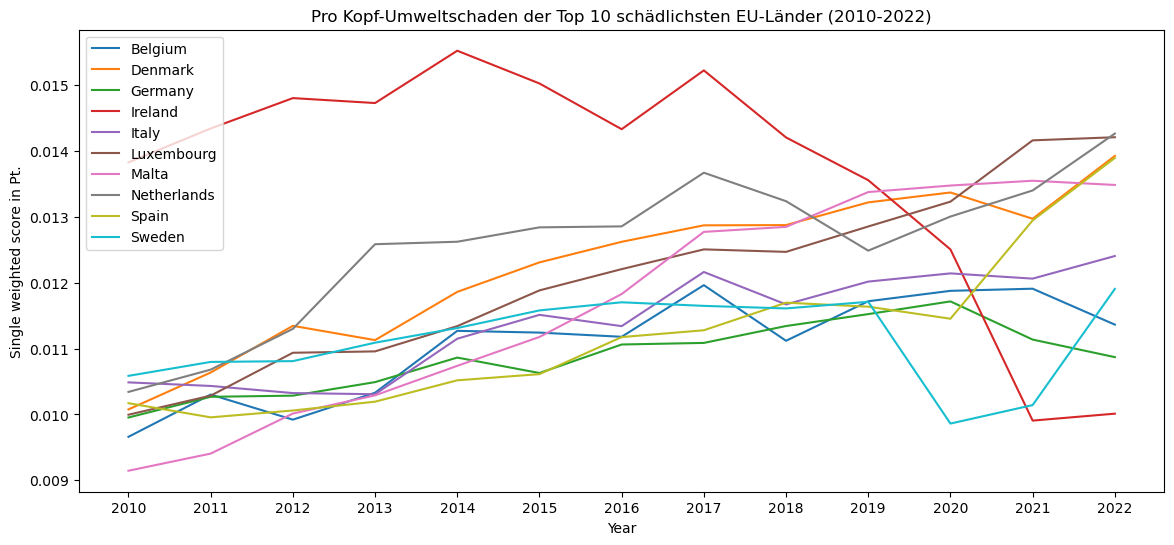

In [160]:
# Grafische Darstellung: Pro Kopf-Impact der Top 10 EU Länder - Single Weighted Score
capita_top_10_countries =['Ireland', 'Netherlands', 'Denmark', 'Luxembourg', 'Malta', 'Italy', 'Spain', 'Sweden', 'Belgium', 'Germany']
plt.figure(figsize=(14,6))
sns.lineplot(x='Year', y='Per Capita', hue='Country', palette='tab10', errorbar=None, data=capita_country_df[(capita_country_df['Impact category'] == 'single weighted score') & (capita_country_df['Country'].isin(capita_top_10_countries))])
plt.ylabel('Single weighted score in Pt.')
plt.title('Pro Kopf-Umweltschaden der Top 10 schädlichsten EU-Länder (2010-2022)')
plt.xticks(ticks=years, labels=years)
plt.legend(loc='upper left')
plt.show()

Man sieht das Irland bis ca. 2019 weit vorne lag und der Single Weighted Score dann rapide nach unten ging. Vorne mit dabei sind seit 2019 Malta, Luxemburg, Dänemark und die Niederlande. In Spanien ist der Score seit 2020 stark angestiegen. 

Betrachten wir nun auch die **10 Länder mit den geringsten Single Weighted Score Werten.**

In [163]:
# 10 Länder mit den geringsten Scores
capita_country_impact_sorted.tail(10)

Impact category  acidification  climate change  ecotoxicity, freshwater  \
Country                                                                   
Austria               1.025575       56.880749              3162.552394   
Greece                0.963327       53.899415              2684.695146   
Croatia               0.942079       53.841855              3075.585066   
Poland                0.907227       56.022981              3504.613316   
Estonia               0.834864       51.415312              2932.483410   
Slovenia              0.878922       52.945317              2871.499494   
Romania               0.608021       41.271671              3465.953595   
Slovakia              0.698464       42.612036              2599.723044   
Hungary               0.637734       41.742700              2679.634108   
Bulgaria              0.617811       40.793909              2651.220254   

Impact category  eutrophication, freshwater  eutrophication, marine  \
Country                                                               
Austria                            0.007016                0.391088   
Greece                             0.005961                0.371567   
Croatia                            0.007133                0.384955   
Poland                             0.007042                0.340045   
Estonia                            0.008124                0.340397   
Slovenia                           0.006487                0.358243   
Romania                            0.006459                0.256060   
Slovakia                           0.005895                0.274473   
Hungary                            0.005734                0.244330   
Bulgaria                           0.005768                0.244387   

Impact category  eutrophication, terrestrial  human toxicity, cancer  \
Country                                                                
Austria                             4.420481            4.622920e-08   
Greece                              4.144374            4.186184e-08   
Croatia                             4.056511            5.291447e-08   
Poland                              3.900876            4.444737e-08   
Estonia                             3.577259            4.637770e-08   
Slovenia                            3.764109            4.774786e-08   
Romania                             2.574579            4.620060e-08   
Slovakia                            2.989842            3.820483e-08   
Hungary                             2.727688            3.552614e-08   
Bulgaria                            2.644768            3.712820e-08   

Impact category  human toxicity, non-cancer  ionising radiation     land use  \
Country                                                                        
Austria                        1.568379e-06            1.008870  2110.350750   
Greece                         1.488234e-06            0.897962  1948.495835   
Croatia                        1.554504e-06            0.958433  2110.363995   
Poland                         1.364092e-06            1.001270  2037.403435   
Estonia                        1.450272e-06            0.967772  2086.384190   
Slovenia                       1.428751e-06            0.940475  2250.179226   
Romania                        1.211302e-06            0.882363  1743.251261   
Slovakia                       1.162046e-06            0.759618  1791.553071   
Hungary                        9.966540e-07            0.765632  1725.101119   
Bulgaria                       1.047298e-06            0.756469  1760.702704   

Impact category  ozone depletion  particulate matter  \
Country                                                
Austria                 0.000047            0.000007   
Greece                  0.000048            0.000007   
Croatia                 0.000044            0.000007   
Poland                  0.000055            0.000007   
Estonia                 0.000038            0.000006   
Slovenia                0.00

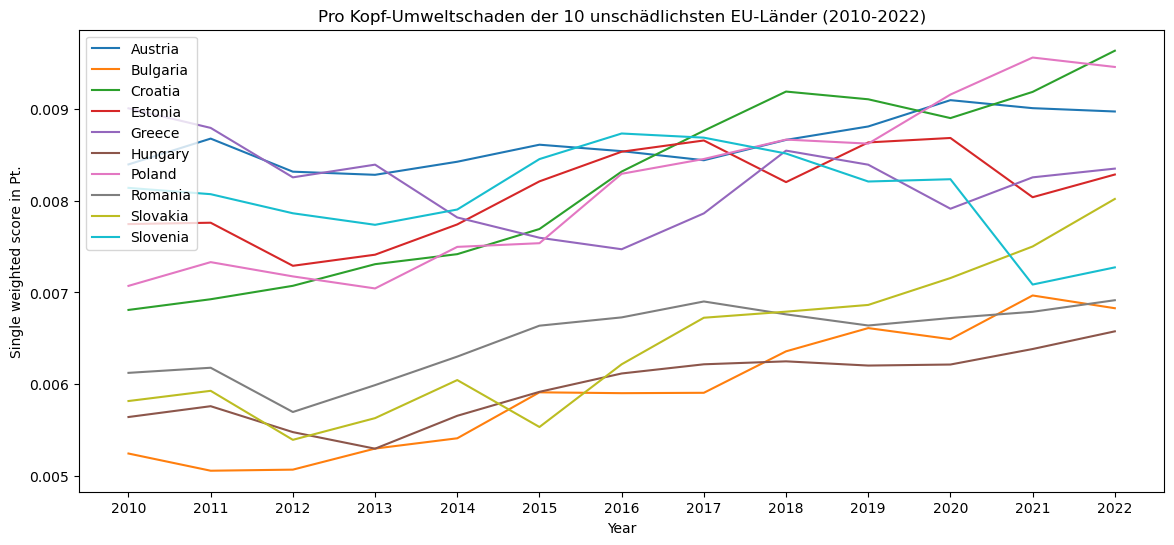

In [164]:
# Grafische Darstellung: Pro Kopf-Impact der Bottom 10 EU Länder - Single Weighted Score
capita_bottom_10_countries =['Bulgaria', 'Hungary', 'Slovakia', 'Romania', 'Slovenia', 'Estonia', 'Poland', 'Croatia', 'Greece', 'Austria']
plt.figure(figsize=(14,6))
sns.lineplot(x='Year', y='Per Capita', hue='Country', palette='tab10', errorbar=None, data=capita_country_df[(capita_country_df['Impact category'] == 'single weighted score') & (capita_country_df['Country'].isin(capita_bottom_10_countries))])
plt.ylabel('Single weighted score in Pt.')
plt.title('Pro Kopf-Umweltschaden der 10 unschädlichsten EU-Länder (2010-2022)')
plt.xticks(ticks=years, labels=years)
plt.legend(loc='upper left')
plt.show()

Man sieht deutlich, dass auch bei den 10 unschädlichsten Ländern ein Trend nach oben zu erkennen ist. Alle Single Weighted Scores liegen 2022 bei über 0,006 pro Kopf. Ganz unten sind Ungarn, Bulgarien und Rumänien. Im oberen Bereich liegen 2022 Kroatien, Polen und Österreich.

#### Ressourcenverbrauch der Länder

Nun möchte ich einmal den Ressourcenverbrauch der Länder beleuchten. **Welche Länder verbrauchen die meisten Ressourcen?** Hier schauen wir uns den Wasser- und fossilen Ressourcenverbrauch an.

In [168]:
# Sortieren nach den Ländern mit dem höchsten Wasserverbrauch -> 10 schlimmsten Länder herausfiltern
capita_country_water_sorted = capita_country_impact_df.sort_values(by='water use', ascending=False)
capita_country_water_sorted.head(10)

Impact category  acidification  climate change  ecotoxicity, freshwater  \
Country                                                                   
Belgium               1.099787       70.143537              4776.855889   
Netherlands           1.446002       80.792882              4534.905325   
Portugal              1.000563       62.574766              3028.832165   
Sweden                1.347101       70.406819              3314.307531   
Luxembourg            1.486881       80.165058              3441.031797   
Ireland               1.874687       86.917205              3595.038192   
Denmark               1.483642       76.765672              4699.108491   
Spain                 1.258413       73.372551              3934.127778   
Estonia               0.834864       51.415312              2932.483410   
Malta                 1.413275       78.557829              3459.886167   

Impact category  eutrophication, freshwater  eutrophication, marine  \
Country                                                               
Belgium                            0.009548                0.451997   
Netherlands                        0.009558                0.570291   
Portugal                           0.010035                0.410455   
Sweden                             0.008384                0.534967   
Luxembourg                         0.009510                0.574862   
Ireland                            0.007437                0.741999   
Denmark                            0.008632                0.592360   
Spain                              0.011397                0.490879   
Estonia                            0.008124                0.340397   
Malta                              0.010651                0.572397   

Impact category  eutrophication, terrestrial  human toxicity, cancer  \
Country                                                                
Belgium                             4.687560            5.888311e-08   
Netherlands                         6.244131            6.001296e-08   
Portugal                            4.263552            4.776420e-08   
Sweden                              5.804446            5.374551e-08   
Luxembourg                          6.421451            5.833351e-08   
Ireland                             8.178333            5.497721e-08   
Denmark                             6.428170            5.462426e-08   
Spain                               5.307816            5.897985e-08   
Estonia                             3.577259            4.637770e-08   
Malta                               6.095809            5.793983e-08   

Impact category  human toxicity, non-cancer  ionising radiation     land use  \
Country                                                                        
Belgium                            0.000002            1.319239  2875.467914   
Netherlands                        0.000002            1.319598  3116.865043   
Portugal                           0.000002            1.153085  2240.938656   
Sweden                             0.000002            1.186728  2673.644623   
Luxembourg                         0.000002            1.275031  3015.188214   
Ireland                            0.000002            1.239718  3113.744461   
Denmark                            0.000002            1.208280  2812.777529   
Spain                              0.000002            1.347536  3000.371228   
Estonia                            0.000001            0.967772  2086.384190   
Malta                              0.000002            1.271936  2902.794208   

Impact category  ozone depletion  particulate matter  \
Country                                                
Belgium                 0.000048            0.000008   
Netherlands             0.000062            0.000011   
Portugal                0.000056            0.000007   
Sweden                  0.000049            0.000010   
Luxembourg              0.000062            0.000011   
Ireland                 0.00

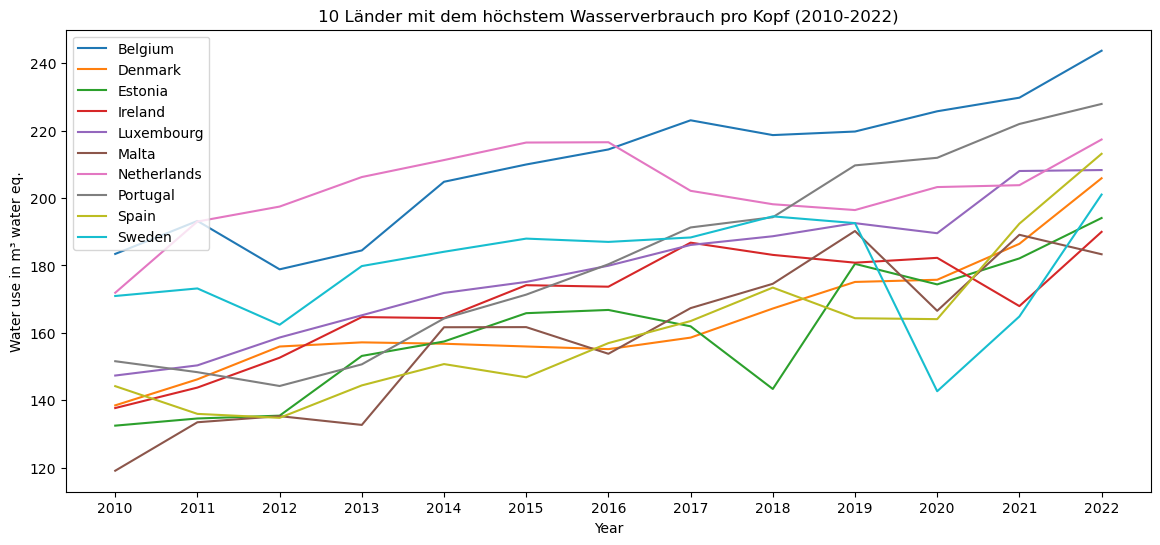

In [169]:
# Water use - Pro Kopf, der Top 10 EU Länder
capita_water_10_countries =['Belgium', 'Netherlands', 'Portugal', 'Sweden', 'Luxembourg', 'Ireland', 'Denmark', 'Spain', 'Estonia', 'Malta']
plt.figure(figsize=(14,6))
sns.lineplot(x='Year', y='Per Capita', hue='Country', palette='tab10', errorbar=None, data=capita_country_df[(capita_country_df['Impact category'] == 'water use') & (capita_country_df['Country'].isin(capita_water_10_countries))])
plt.ylabel('Water use in m³ water eq.')
plt.title('10 Länder mit dem höchstem Wasserverbrauch pro Kopf (2010-2022)')
plt.xticks(ticks=years, labels=years)
plt.legend(loc='upper left')
plt.show()

Der Wasserverbauch ist seit 2016 in Belgien stetig am höchsten (über 220 m³ Wasser), gefolgt von Portugal, den Niederlanden und Spanien. Schweden war bis 2019 auch weit oben dabei, konnte aber den Wasserverbrauch zwischendurch stark senken. 2022 liegt Schweden allerdings auch wieder in den Top 7.

In [171]:
# Sortieren nach den Ländern mit dem höchsten fossilen Ressourcenverbrauch -> 10 schlimmsten Länder herausfiltern
capita_country_fossils_sorted = capita_country_impact_df.sort_values(by='resource use, fossil', ascending=False)
capita_country_fossils_sorted.head(10)

Impact category  acidification  climate change  ecotoxicity, freshwater  \
Country                                                                   
Spain                 1.258413       73.372551              3934.127778   
Malta                 1.413275       78.557829              3459.886167   
Netherlands           1.446002       80.792882              4534.905325   
Luxembourg            1.486881       80.165058              3441.031797   
Italy                 1.416643       74.264328              3155.399892   
Belgium               1.099787       70.143537              4776.855889   
Ireland               1.874687       86.917205              3595.038192   
Denmark               1.483642       76.765672              4699.108491   
Sweden                1.347101       70.406819              3314.307531   
Germany               1.315011       71.662772              3444.498227   

Impact category  eutrophication, freshwater  eutrophication, marine  \
Country                                                               
Spain                              0.011397                0.490879   
Malta                              0.010651                0.572397   
Netherlands                        0.009558                0.570291   
Luxembourg                         0.009510                0.574862   
Italy                              0.008192                0.546531   
Belgium                            0.009548                0.451997   
Ireland                            0.007437                0.741999   
Denmark                            0.008632                0.592360   
Sweden                             0.008384                0.534967   
Germany                            0.007551                0.498475   

Impact category  eutrophication, terrestrial  human toxicity, cancer  \
Country                                                                
Spain                               5.307816            5.897985e-08   
Malta                               6.095809            5.793983e-08   
Netherlands                         6.244131            6.001296e-08   
Luxembourg                          6.421451            5.833351e-08   
Italy                               6.083294            5.539611e-08   
Belgium                             4.687560            5.888311e-08   
Ireland                             8.178333            5.497721e-08   
Denmark                             6.428170            5.462426e-08   
Sweden                              5.804446            5.374551e-08   
Germany                             5.678893            5.702619e-08   

Impact category  human toxicity, non-cancer  ionising radiation     land use  \
Country                                                                        
Spain                              0.000002            1.347536  3000.371228   
Malta                              0.000002            1.271936  2902.794208   
Netherlands                        0.000002            1.319598  3116.865043   
Luxembourg                         0.000002            1.275031  3015.188214   
Italy                              0.000002            1.248377  2855.725171   
Belgium                            0.000002            1.319239  2875.467914   
Ireland                            0.000002            1.239718  3113.744461   
Denmark                            0.000002            1.208280  2812.777529   
Sweden                             0.000002            1.186728  2673.644623   
Germany                            0.000002            1.203332  2778.890090   

Impact category  ozone depletion  particulate matter  \
Country                                                
Spain                   0.000061            0.000009   
Malta                   0.000058            0.000010   
Netherlands             0.000062            0.000011   
Luxembourg              0.000062            0.000011   
Italy                   0.000058            0.000010   
Belgium                 0.00

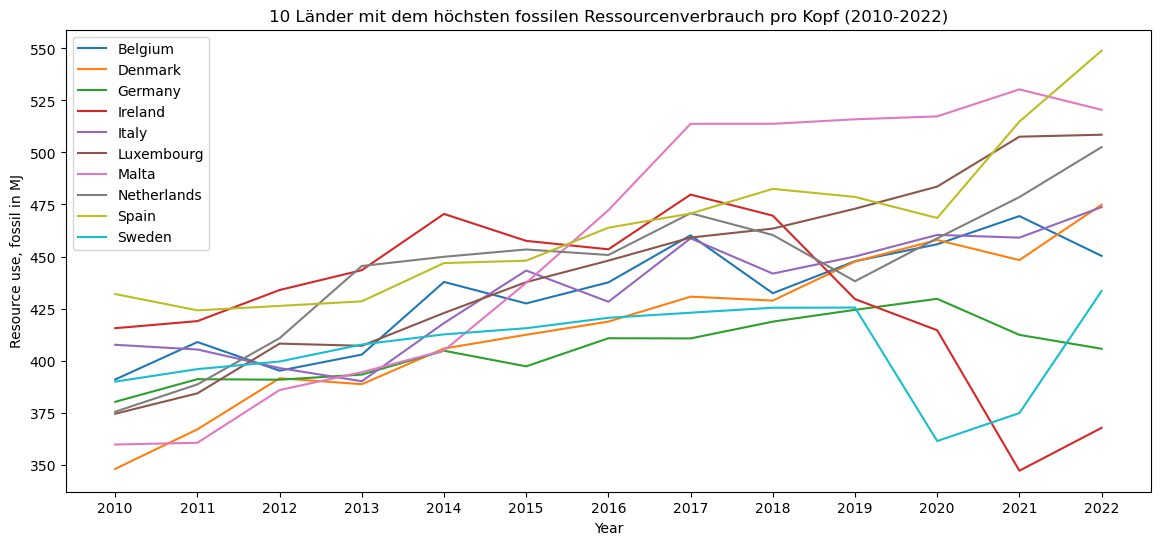

In [172]:
# Resource use, fossil - Pro Kopf, der Top 10 EU Länder
capita_fossils_10_countries =['Spain', 'Malta', 'Netherlands', 'Luxembourg', 'Italy', 'Belgium', 'Ireland', 'Denmark', 'Sweden', 'Germany']
plt.figure(figsize=(14,6))
sns.lineplot(x='Year', y='Per Capita', hue='Country', palette='tab10', errorbar=None, data=capita_country_df[(capita_country_df['Impact category'] == 'resource use, fossil') & (capita_country_df['Country'].isin(capita_fossils_10_countries))])
plt.ylabel('Resource use, fossil in MJ')
plt.title('10 Länder mit dem höchsten fossilen Ressourcenverbrauch pro Kopf (2010-2022)')
plt.xticks(ticks=years, labels=years)
plt.legend(loc='upper left')
plt.show()

Beim fossilen Ressourcenverbrauch ist Malta seit ca. 2015 an oberster Stelle, wurde aber von Spanien im Jahr 2021 überholt. Die Niederlande und Luxemburg sind auch weiter oben dabei. Alle liegen 2022 bei über 500 Megajoule pro Kopf. Insgesamt geht der Trend nach oben, auch wenn Schweden und Irland hier wieder starke Senkungen seit 2019 verzeichnen konnten.

**Zwischenfazit**: In allen untersuchten Kategorien lässt sich mit einzelnen Ausnahmen ein steigender Trend in den pro Kopf Werten erkennen. Vor allem Irland, Dänemark und die Niederlande zeigen die höchsten Gesamtscores im Schnitt über die Jahre an. Irland konnte die Werte aber seit 2017 senken. Spanien hat dagegen vor allem im Wasser- und fossilen Ressourcenverbrauch seit 2020 einen stetigen Ansteig verzeichnet. Man müsste sich nun die Länder, die ihre Werte senken konnten, einmal im Detail anschauen.
Zusätzlich ist zu sagen, dass ich immer mit den demografischen Daten aus dem Jahr 2024 gerechnet habe. Die demografischen Zahlen haben sich natürlich über die Jahre geändert. Allerdings gab es in keinem der Länder extreme Sprünge, sodass die Werte und Kurven sich ähnlich verhalten würden.

### Betrachtung der Planetary Boundaries

Da wir Informationen zu den weltweiten Grenzwerten haben, untersuche ich zuletzt, ob, wo und wie weit die EU diese Werte überschreitet.

Dazu rechne ich als erstes die Planetary Boundaries pro Kopf aus. Und füge diese als weitere Spalte hinzu. Die Weltbevölkerung liegt 2022 ungefähr bei 8 Milliarden Menschen.

In [178]:
# Planetary Boundaries pro Kopf ausrechnen
impact_assessment_df['Planetary boundary per capita'] = impact_assessment_df['Planetary boundary'] / 8000000000
impact_assessment_df

Impact category               Unit  \
0                      acidification          mol H+ eq   
1                     climate change          kg CO2 eq   
2            ecotoxicity, freshwater               CTUe   
3         eutrophication, freshwater            kg P eq   
4             eutrophication, marine            kg N eq   
5        eutrophication, terrestrial           mol N eq   
6             human toxicity, cancer               CTUh   
7         human toxicity, non-cancer               CTUh   
8                 ionising radiation        kBq U235 eq   
9                           land use                Pt.   
10                   ozone depletion       kg CFC-11 eq   
11                particulate matter  disease incidence   
12     photochemical ozone formation        kg NMVOC eq   
13              resource use, fossil     megajoule (MJ)   
14  resource use, mineral and metals           kg Sb eq   
15                         water use        m3 water eq   

    Global normalization factor  Weighting factor  Planetary boundary  \
0                     55.600000            0.0620        1.000000e+12   
1                   7550.000000            0.2106        6.810000e+12   
2                  56700.000000            0.0192        1.310000e+14   
3                      1.610000            0.0280        5.810000e+09   
4                     19.500000            0.0296        2.010000e+11   
5                    177.000000            0.0371        6.130000e+12   
6                      0.000017            0.0184        9.620000e+05   
7                      0.000129            0.0213        4.100000e+06   
8                   4220.000000            0.0501        5.270000e+14   
9                 819000.000000            0.0794        3.980000e+15   
10                     0.052300            0.0631        5.390000e+08   
11                     0.000595            0.0896        5.160000e+05   
12                    40.900000            0.0478        4.070000e+11   
13                 65000.000000            0.0832        2.240000e+14   
14                     0.063600            0.0755        2.190000e+08   
15                 11500.000000            0.0851        1.820000e+14   

    Planetary boundary per capita  
0                      125.000000  
1                      851.250000  
2                    16375.000000  
3                        0.726250  
4                       25.125000  
5                      766.250000  
6                        0.000120  
7                        0.000513  
8                    65875.000000  
9                   497500.000000  
10                       0.067375  
11                       0.000064  
12                      50.875000  
13                   28000.000000  
14                       0.027375  
15                   22750.000000

In [179]:
# Einheiten der EU-Tabelle
capita_eu_df[['Impact category', 'Unit']].groupby('Impact category').value_counts()

Impact category                   Unit                     
acidification                     billion mol H⁺ eq.           598
climate change                    billion tonnes CO₂ eq.       598
ecotoxicity, freshwater           trillion CTUe                598
eutrophication, freshwater        thousand tonnes P eq.        598
eutrophication, marine            million tonnes N eq.         598
eutrophication, terrestrial       billion mol N eq.            598
human toxicity, cancer            thousand CTUh                598
human toxicity, non-cancer        thousand CTUh                598
ionising radiation                million tonnes U-235 eq.     598
land use                          trillion Pt.                 598
ozone depletion                   thousand tonnes CFC-11 eq    598
particulate matter                disease incidence (x1000)    598
photochemical ozone formation     million tonnes NMVOC eq.     598
resource use, fossil              exajoule (EJ)                598
re

Auch hier müssen wieder die Einheiten angepasst werden, damit die pro Kopf Werte vergleichbar sind.

In [181]:
# Werte und jeweilige Units anpassen

# Acidification, Climate Change, Eutrophication, terrestrial & Single Weighted Score -> Billion (Milliarden)
capita_eu_df.loc[capita_eu_df['Impact category'].isin(['acidification', 'climate change', 'eutrophication, terrestrial', 'single weighted score']), ['Per Capita']] *= 1000000000
capita_eu_df.loc[
    capita_eu_df['Impact category'].isin(['acidification', 'climate change', 'eutrophication, terrestrial', 'single weighted score']),
    'Unit'
] = capita_eu_df.loc[
    capita_eu_df['Impact category'].isin(['acidification', 'climate change', 'eutrophication, terrestrial', 'single weighted score']),
    'Unit'
].str.replace('billion ', '', regex=False)

In [182]:
# Ecotoxicity, freshwater, Land use, Resource use, fossil & Water use -> Trillion (Billionen)
capita_eu_df.loc[capita_eu_df['Impact category'].isin(['ecotoxicity, freshwater', 'land use', 'resource use, fossil', 'water use']), ['Per Capita']] *= 1000000000000
capita_eu_df.loc[
    capita_eu_df['Impact category'].isin(['ecotoxicity, freshwater', 'land use', 'water use']),
    'Unit'
] = capita_eu_df.loc[
    capita_eu_df['Impact category'].isin(['ecotoxicity, freshwater', 'land use', 'water use']),
    'Unit'
].str.replace('trillion ', '', regex=False)
capita_eu_df.loc[
    capita_eu_df['Impact category'] == 'resource use, fossil',
    'Unit'
] = capita_eu_df.loc[
    capita_eu_df['Impact category'] == 'resource use, fossil',
    'Unit'
].str.replace('exajoule (EJ)', 'megajoule (MJ)', regex=False)

In [183]:
# Eutrophication, freshwater, Human Toxicity, cancer, Human Toxicity, non-cancer, Ozone Depletion, Particulate Matter
# Resource use, mineral & metals -> Tausend
capita_eu_df.loc[capita_eu_df['Impact category'].isin(['eutrophication, freshwater', 'human toxicity, cancer', 'human toxicity, non-cancer', 'ozone depletion', 'particulate matter', 'resource use, mineral and metals']), ['Per Capita']] *= 1000
capita_eu_df.loc[
    capita_eu_df['Impact category'].isin(['eutrophication, freshwater', 'human toxicity, cancer', 'human toxicity, non-cancer', 'ozone depletion', 'resource use, mineral and metals']),
    'Unit'
] = capita_eu_df.loc[
    capita_eu_df['Impact category'].isin(['eutrophication, freshwater', 'human toxicity, cancer', 'human toxicity, non-cancer', 'ozone depletion', 'resource use, mineral and metals']),
    'Unit'
].str.replace('thousand ', '', regex=False)
capita_eu_df.loc[
    capita_eu_df['Impact category'] == 'particulate matter',
    'Unit'
] = capita_eu_df.loc[
    capita_eu_df['Impact category'] == 'particulate matter',
    'Unit'
].str.replace('(x1000)', '', regex=False)

In [184]:
# Eutrophication, marine, Ionising Radiation & Photochemical Ozone Formation -> Millionen
capita_eu_df.loc[capita_eu_df['Impact category'].isin(['eutrophication, marine', 'ionising radiation', 'photochemical ozone formation']), ['Per Capita']] *= 1000000
capita_eu_df.loc[
    capita_eu_df['Impact category'].isin(['eutrophication, marine', 'ionising radiation', 'photochemical ozone formation']),
    'Unit'
] = capita_eu_df.loc[
    capita_eu_df['Impact category'].isin(['eutrophication, marine', 'ionising radiation', 'photochemical ozone formation']),
    'Unit'
].str.replace('million ', '', regex=False)

In [185]:
# Tonnes in kg
capita_eu_df.loc[capita_eu_df['Impact category'].isin(['climate change', 'eutrophication, freshwater', 'eutrophication, marine', 'ionising radiation', 'ozone depletion', 'photochemical ozone formation', 'resource use, mineral and metals']), ['Per Capita']] *= 1000
capita_eu_df.loc[
    capita_eu_df['Impact category'].isin(['climate change', 'eutrophication, freshwater', 'eutrophication, marine', 'ionising radiation', 'ozone depletion', 'photochemical ozone formation', 'resource use, mineral and metals']),
    'Unit'
] = capita_eu_df.loc[
    capita_eu_df['Impact category'].isin(['climate change', 'eutrophication, freshwater', 'eutrophication, marine', 'ionising radiation', 'ozone depletion', 'photochemical ozone formation', 'resource use, mineral and metals']),
    'Unit'
].str.replace('tonnes ', 'kg ', regex=False)

In [186]:
# Prüfen der Einheiten
capita_eu_df[['Impact category', 'Unit']].groupby('Impact category').value_counts()

Impact category                   Unit              
acidification                     mol H⁺ eq.            598
climate change                    kg CO₂ eq.            598
ecotoxicity, freshwater           CTUe                  598
eutrophication, freshwater        kg P eq.              598
eutrophication, marine            kg N eq.              598
eutrophication, terrestrial       mol N eq.             598
human toxicity, cancer            CTUh                  598
human toxicity, non-cancer        CTUh                  598
ionising radiation                kg U-235 eq.          598
land use                          Pt.                   598
ozone depletion                   kg CFC-11 eq          598
particulate matter                disease incidence     598
photochemical ozone formation     kg NMVOC eq.          598
resource use, fossil              megajoule (MJ)        598
resource use, mineral and metals  kg Sb eq.             598
single weighted score             pt           

In [187]:
# Tabelle auf wichtige Spalten reduzieren
capita_eu_df = capita_eu_df[['Product group', 'Product', 'Year', 'Impact category', 'Per Capita', 'Unit']]
capita_eu_df

Product group   Product  Year                   Impact category  \
0          Beverages      Beer  2010                     acidification   
27         Beverages      Beer  2010                    climate change   
80         Beverages      Beer  2010           ecotoxicity, freshwater   
88         Beverages      Beer  2010        eutrophication, freshwater   
108        Beverages      Beer  2010            eutrophication, marine   
...              ...       ...   ...                               ...   
274347    Vegetables  Tomatoes  2022     photochemical ozone formation   
274374    Vegetables  Tomatoes  2022              resource use, fossil   
274408    Vegetables  Tomatoes  2022  resource use, mineral and metals   
274428    Vegetables  Tomatoes  2022             single weighted score   
274462    Vegetables  Tomatoes  2022                         water use   

         Per Capita            Unit  
0          0.468978      mol H⁺ eq.  
27        75.328805      kg CO₂ eq.  
80      2410.588280            CTUe  
88         0.052566        kg P eq.  
108        0.286845        kg N eq.  
...             ...             ...  
274347     0.195162    kg NMVOC eq.  
274374   738.092694  megajoule (MJ)  
274408     0.000481       kg Sb eq.  
274428     0.008198              pt  
274462   205.921032    m³ water eq.  

[10166 rows x 6 columns]

Nun rechne ich für jede Impact Kategorie und jedes Jahr aus wie hoch die Werte in Summe sind, um sie dem Grenzwert gegenüber zu stellen.

In [189]:
# EU-weiter Impact je Kategorie und Jahr in Summe über die Produkte
impact_capita_eu_df = capita_eu_df[['Impact category', 'Year', 'Per Capita']].groupby(['Impact category', 'Year']).sum().reset_index()
impact_capita_eu_df

Impact category  Year   Per Capita
0     acidification  2010    47.325676
1     acidification  2011    47.137586
2     acidification  2012    48.240492
3     acidification  2013    48.603836
4     acidification  2014    50.651089
..              ...   ...          ...
216       water use  2018  6327.914005
217       water use  2019  6355.226349
218       water use  2020  6494.087162
219       water use  2021  6709.748066
220       water use  2022  6787.166801

[221 rows x 3 columns]

#### EU-Werte vs. weltweite Grenzwerte für die 4 wichtigsten Impact Kategorien

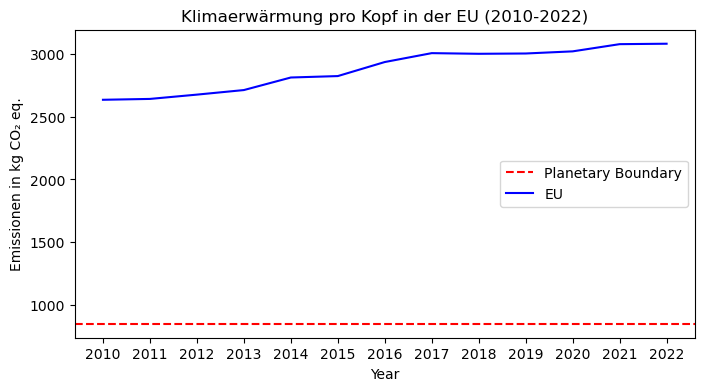

In [191]:
# Climate Change - EU vs. Planetary Boundary
planetary_boundary_climate = impact_assessment_df.loc[impact_assessment_df['Impact category'] == 'climate change', 'Planetary boundary per capita'].item()
plt.figure(figsize=(8,4))
plt.axhline(y=planetary_boundary_climate, color='r', linestyle='--', label='Planetary Boundary')            
sns.lineplot(x='Year', y='Per Capita', color='b', errorbar=None, data=impact_capita_eu_df[impact_capita_eu_df['Impact category'] == 'climate change'], label='EU')
plt.ylabel('Emissionen in kg CO₂ eq.')
plt.title('Klimaerwärmung pro Kopf in der EU (2010-2022)')
plt.xticks(ticks=years, labels=years)
plt.legend(loc='right')
plt.show()

Der weltweite Grenzwert pro Kopf für CO₂ Emissionen wurde jedes Jahr EU-weit deutlich überschritten. 2022 war er ca. 3,5 mal so hoch.

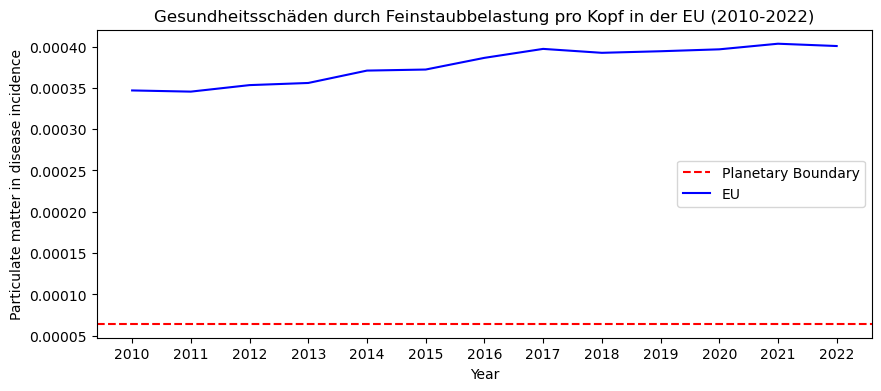

In [193]:
# Particulate matter - EU vs. Planetary Boundary
planetary_boundary_pm = impact_assessment_df.loc[impact_assessment_df['Impact category'] == 'particulate matter', 'Planetary boundary per capita'].item()
plt.figure(figsize=(10,4))
plt.axhline(y=planetary_boundary_pm, color='r', linestyle='--', label='Planetary Boundary')            
sns.lineplot(x='Year', y='Per Capita', color='b', errorbar=None, data=impact_capita_eu_df[impact_capita_eu_df['Impact category'] == 'particulate matter'], label='EU')
plt.ylabel('Particulate matter in disease incidence')
plt.title('Gesundheitsschäden durch Feinstaubbelastung pro Kopf in der EU (2010-2022)')
plt.xticks(ticks=years, labels=years)
plt.legend(loc='right')
plt.show()

Auch bei den Inzidenzen durch Feinstaubbelastung liegt der EU-Wert jedes Jahr deutlich über dem Grenzwert. Er ist ca. 5-6 mal so hoch.

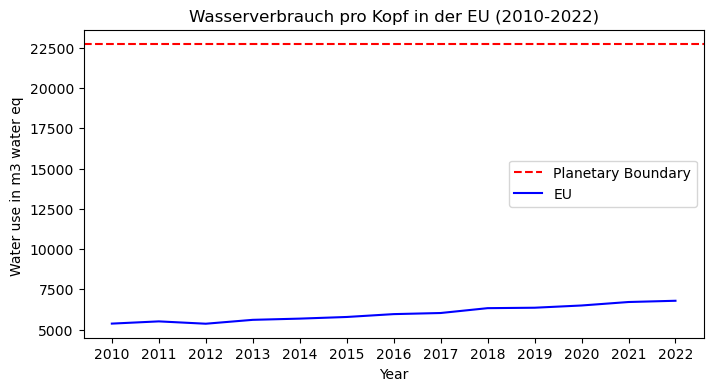

In [195]:
# Water use - EU vs. Planetary Boundary
planetary_boundary_water = impact_assessment_df.loc[impact_assessment_df['Impact category'] == 'water use', 'Planetary boundary per capita'].item()
plt.figure(figsize=(8,4))
plt.axhline(y=planetary_boundary_water, color='r', linestyle='--', label='Planetary Boundary')            
sns.lineplot(x='Year', y='Per Capita', color='b', errorbar=None, data=impact_capita_eu_df[impact_capita_eu_df['Impact category'] == 'water use'], label='EU')
plt.ylabel('Water use in m3 water eq ')
plt.title('Wasserverbrauch pro Kopf in der EU (2010-2022)')
plt.xticks(ticks=years, labels=years)
plt.legend(loc='right')
plt.show()

Beim Wasserverbrauch liegen die EU-Werte noch deutlich unter dem weltweiten Grenzwert, bei etwa 25%-30% des Grenzwertes.

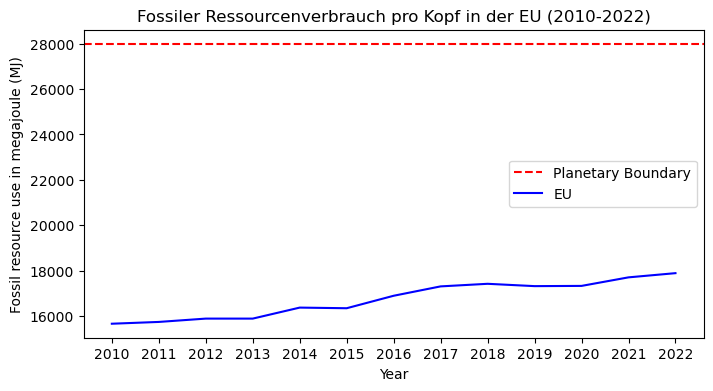

In [197]:
# Fossil resources - EU vs. Planetary Boundary
planetary_boundary_fossils = impact_assessment_df.loc[impact_assessment_df['Impact category'] == 'resource use, fossil', 'Planetary boundary per capita'].item()
plt.figure(figsize=(8,4))
plt.axhline(y=planetary_boundary_fossils, color='r', linestyle='--', label='Planetary Boundary')            
sns.lineplot(x='Year', y='Per Capita', color='b', errorbar=None, data=impact_capita_eu_df[impact_capita_eu_df['Impact category'] == 'resource use, fossil'], label='EU')
plt.ylabel('Fossil resource use in megajoule (MJ)')
plt.title('Fossiler Ressourcenverbrauch pro Kopf in der EU (2010-2022)')
plt.xticks(ticks=years, labels=years)
plt.legend(loc='right')
plt.show()

Auch beim fossilen Ressourcenverbrauch liegt die EU noch im grünen Bereich. Hier sieht man aber deutlich, wie der Verbrauch angestiegen ist und 2022 bei ca. 60% des Grenzwertes liegt.

#### Die größten Überschreitungen der Grenzwerte

Abschließend möchte ich nochmal für alle Kategorien die Durchschnittswerte über die Jahre und ihre Grenzwerte vergleichen. So kann ich herausfinden, in welchen Kategorien die Grenzwerte am meisten überschritten wurden.

In [201]:
# Jahresdurchschnitt pro Impact Kategorie ausrechnen
impact_average_eu_df = impact_capita_eu_df[['Impact category', 'Per Capita']].groupby(['Impact category']).mean().reset_index()
impact_average_eu_df

Impact category     Per Capita
0                      acidification      51.653416
1                     climate change    2878.586847
2            ecotoxicity, freshwater  151228.850852
3         eutrophication, freshwater       0.347257
4             eutrophication, marine      20.079181
5        eutrophication, terrestrial     222.221193
6             human toxicity, cancer       0.000002
7         human toxicity, non-cancer       0.000076
8                 ionising radiation      48.918468
9                           land use  108373.904628
10                   ozone depletion       0.002380
11                particulate matter       0.000378
12     photochemical ozone formation       6.078921
13              resource use, fossil   16744.956677
14  resource use, mineral and metals       0.005714
15             single weighted score       0.437473
16                         water use    5996.797417

Nun ziehe ich mir wieder relevanten Spalten aus der Impact Assessment Tabelle und merge sie dann mit impact_average_eu_df

In [203]:
# Impact Assessment Tabelle nach den relevanten Spalten filtern
planetary_boundary_df = impact_assessment_df[['Impact category', 'Planetary boundary per capita']]

In [204]:
# Mergen der Tabellen
eu_boundary_df = pd.merge(impact_average_eu_df, planetary_boundary_df, on='Impact category')
eu_boundary_df

Impact category     Per Capita  \
0                      acidification      51.653416   
1                     climate change    2878.586847   
2            ecotoxicity, freshwater  151228.850852   
3         eutrophication, freshwater       0.347257   
4             eutrophication, marine      20.079181   
5        eutrophication, terrestrial     222.221193   
6             human toxicity, cancer       0.000002   
7         human toxicity, non-cancer       0.000076   
8                 ionising radiation      48.918468   
9                           land use  108373.904628   
10                   ozone depletion       0.002380   
11                particulate matter       0.000378   
12     photochemical ozone formation       6.078921   
13              resource use, fossil   16744.956677   
14  resource use, mineral and metals       0.005714   
15                         water use    5996.797417   

    Planetary boundary per capita  
0                      125.000000  
1                      851.250000  
2                    16375.000000  
3                        0.726250  
4                       25.125000  
5                      766.250000  
6                        0.000120  
7                        0.000513  
8                    65875.000000  
9                   497500.000000  
10                       0.067375  
11                       0.000064  
12                      50.875000  
13                   28000.000000  
14                       0.027375  
15                   22750.000000

Nun füge ich noch eine Spalte 'Transgression' hinzu, die mir anzeigt um wie viel höher der Wert vom Grenzwert ist.

In [206]:
# Weitere Spalte mit Vielfachem der Boundary hinzufügen
eu_boundary_df['Transgression'] = (eu_boundary_df['Per Capita'] / eu_boundary_df['Planetary boundary per capita']).round(3)
eu_boundary_df

Impact category     Per Capita  \
0                      acidification      51.653416   
1                     climate change    2878.586847   
2            ecotoxicity, freshwater  151228.850852   
3         eutrophication, freshwater       0.347257   
4             eutrophication, marine      20.079181   
5        eutrophication, terrestrial     222.221193   
6             human toxicity, cancer       0.000002   
7         human toxicity, non-cancer       0.000076   
8                 ionising radiation      48.918468   
9                           land use  108373.904628   
10                   ozone depletion       0.002380   
11                particulate matter       0.000378   
12     photochemical ozone formation       6.078921   
13              resource use, fossil   16744.956677   
14  resource use, mineral and metals       0.005714   
15                         water use    5996.797417   

    Planetary boundary per capita  Transgression  
0                      125.000000          0.413  
1                      851.250000          3.382  
2                    16375.000000          9.235  
3                        0.726250          0.478  
4                       25.125000          0.799  
5                      766.250000          0.290  
6                        0.000120          0.019  
7                        0.000513          0.148  
8                    65875.000000          0.001  
9                   497500.000000          0.218  
10                       0.067375          0.035  
11                       0.000064          5.862  
12                      50.875000          0.119  
13                   28000.000000          0.598  
14                       0.027375          0.209  
15                   22750.000000          0.264

In [207]:
# Sortieren nach höchster Transgression
eu_boundary_df.sort_values(by='Transgression', ascending=False)

Impact category     Per Capita  \
2            ecotoxicity, freshwater  151228.850852   
11                particulate matter       0.000378   
1                     climate change    2878.586847   
4             eutrophication, marine      20.079181   
13              resource use, fossil   16744.956677   
3         eutrophication, freshwater       0.347257   
0                      acidification      51.653416   
5        eutrophication, terrestrial     222.221193   
15                         water use    5996.797417   
9                           land use  108373.904628   
14  resource use, mineral and metals       0.005714   
7         human toxicity, non-cancer       0.000076   
12     photochemical ozone formation       6.078921   
10                   ozone depletion       0.002380   
6             human toxicity, cancer       0.000002   
8                 ionising radiation      48.918468   

    Planetary boundary per capita  Transgression  
2                    16375.000000          9.235  
11                       0.000064          5.862  
1                      851.250000          3.382  
4                       25.125000          0.799  
13                   28000.000000          0.598  
3                        0.726250          0.478  
0                      125.000000          0.413  
5                      766.250000          0.290  
15                   22750.000000          0.264  
9                   497500.000000          0.218  
14                       0.027375          0.209  
7                        0.000513          0.148  
12                      50.875000          0.119  
10                       0.067375          0.035  
6                        0.000120          0.019  
8                    65875.000000          0.001

Im Schnitt ist der EU-weite Wert von **Exotoxicity, freshwater etwa 9 mal so hoch wie die weltweite Grenze**. Dieser Indikator bezieht sich auf die Vergiftung des Ökosystems. Dieses Ergebnis ist sehr erschreckend. Die **weltweite Grenze wird ebenfalls von den Kategorien Particulate matter und Climate Change überschritten**. Die Werte für Eutrophication, marine (Enthaltener Stickstoff in marinen Ökosystemen) und für fossilen Ressourcenverbrauch liegen aber auch schon gefährlich nahe an der weltweiten Grenze.

#### Grenzwerte und Lebensmittelgruppen

Bei den kritischen Impact Kategorien möchte ich nun analysieren, welche Lebensmittelgruppen besonders zu diesen Grenzwertüberschreitungen beitragen. Hierfür ziehe ich nochmal die Heatmap der Impact Kategorien und Lebensmittelgruppen hinzu.

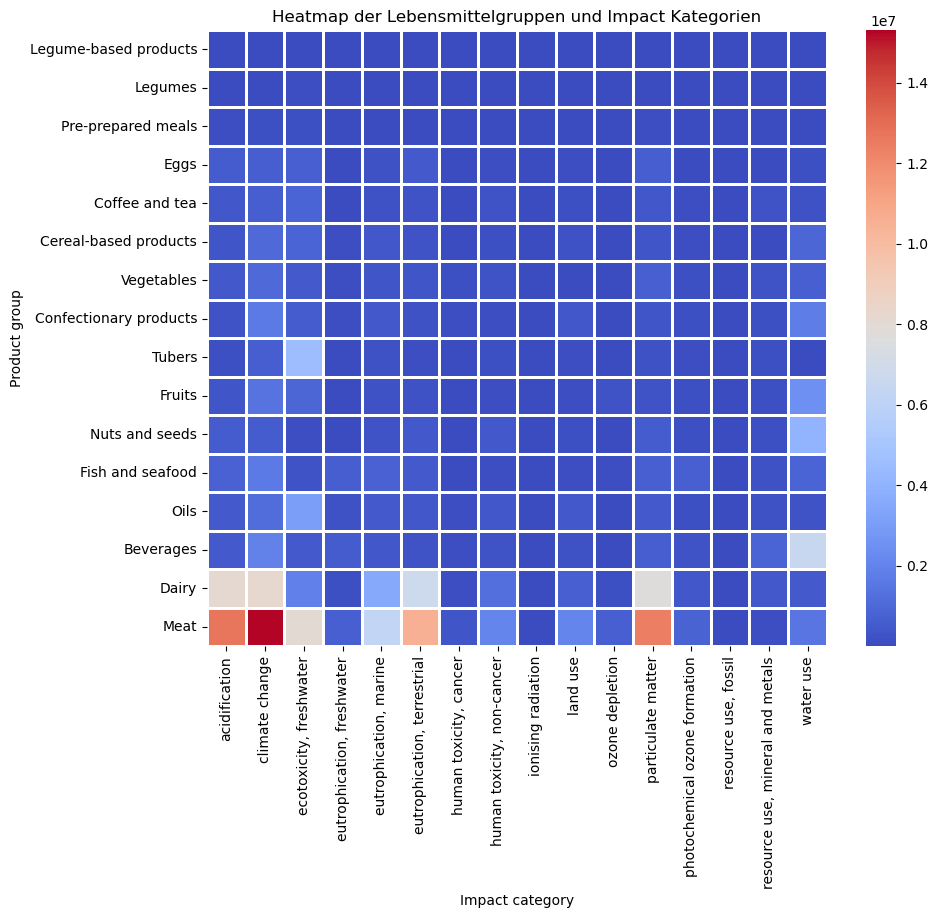

In [211]:
# Heatmap der Impact Kategorien & Lebensmittelgruppen
plt.figure(figsize=(10, 8))
sns.heatmap(weighted_product_group_impact_df, annot=False, cmap='coolwarm', linewidths=0.8)
plt.title('Heatmap der Lebensmittelgruppen und Impact Kategorien')
plt.show()

Bei Ecotoxicity sind vor allem Fleischprodukte, Kartoffeln, Öle und Milchprodukte die ausschlaggebenden Lebensmittelgruppen. Bei Particulate Matter und Climate Change sind es Fleisch- und Milchprodukte.

#### Grenzwerte und Länder

Nun betrachte ich die Länder. Dazu hole ich mir nochmal die Ländertabelle und sortiere sie nach den jeweiligen Impact Kategorien.

In [215]:
# Sortieren nach den Ländern mit den höchsten Ecotoxicity-Werten -> 10 Länder herausfiltern
capita_country_impact_ecotoxicity = capita_country_impact_df.sort_values(by='ecotoxicity, freshwater', ascending=False)
capita_country_impact_ecotoxicity.head(10)

Impact category  acidification  climate change  ecotoxicity, freshwater  \
Country                                                                   
Belgium               1.099787       70.143537              4776.855889   
Denmark               1.483642       76.765672              4699.108491   
Netherlands           1.446002       80.792882              4534.905325   
Latvia                1.025215       63.009712              4235.677502   
Spain                 1.258413       73.372551              3934.127778   
Lithuania             0.986058       58.777096              3657.164124   
Ireland               1.874687       86.917205              3595.038192   
Poland                0.907227       56.022981              3504.613316   
Romania               0.608021       41.271671              3465.953595   
Malta                 1.413275       78.557829              3459.886167   

Impact category  eutrophication, freshwater  eutrophication, marine  \
Country                                                               
Belgium                            0.009548                0.451997   
Denmark                            0.008632                0.592360   
Netherlands                        0.009558                0.570291   
Latvia                             0.008440                0.406566   
Spain                              0.011397                0.490879   
Lithuania                          0.008737                0.391903   
Ireland                            0.007437                0.741999   
Poland                             0.007042                0.340045   
Romania                            0.006459                0.256060   
Malta                              0.010651                0.572397   

Impact category  eutrophication, terrestrial  human toxicity, cancer  \
Country                                                                
Belgium                             4.687560            5.888311e-08   
Denmark                             6.428170            5.462426e-08   
Netherlands                         6.244131            6.001296e-08   
Latvia                              4.333295            5.387982e-08   
Spain                               5.307816            5.897985e-08   
Lithuania                           4.256331            4.935605e-08   
Ireland                             8.178333            5.497721e-08   
Poland                              3.900876            4.444737e-08   
Romania                             2.574579            4.620060e-08   
Malta                               6.095809            5.793983e-08   

Impact category  human toxicity, non-cancer  ionising radiation     land use  \
Country                                                                        
Belgium                            0.000002            1.319239  2875.467914   
Denmark                            0.000002            1.208280  2812.777529   
Netherlands                        0.000002            1.319598  3116.865043   
Latvia                             0.000002            1.204790  2531.366630   
Spain                              0.000002            1.347536  3000.371228   
Lithuania                          0.000002            1.023526  2301.054825   
Ireland                            0.000002            1.239718  3113.744461   
Poland                             0.000001            1.001270  2037.403435   
Romania                            0.000001            0.882363  1743.251261   
Malta                              0.000002            1.271936  2902.794208   

Impact category  ozone depletion  particulate matter  \
Country                                                
Belgium                 0.000048            0.000008   
Denmark                 0.000059            0.000011   
Netherlands             0.000062            0.000011   
Latvia                  0.000048            0.000008   
Spain                   0.000061            0.000009   
Lithuania               0.00

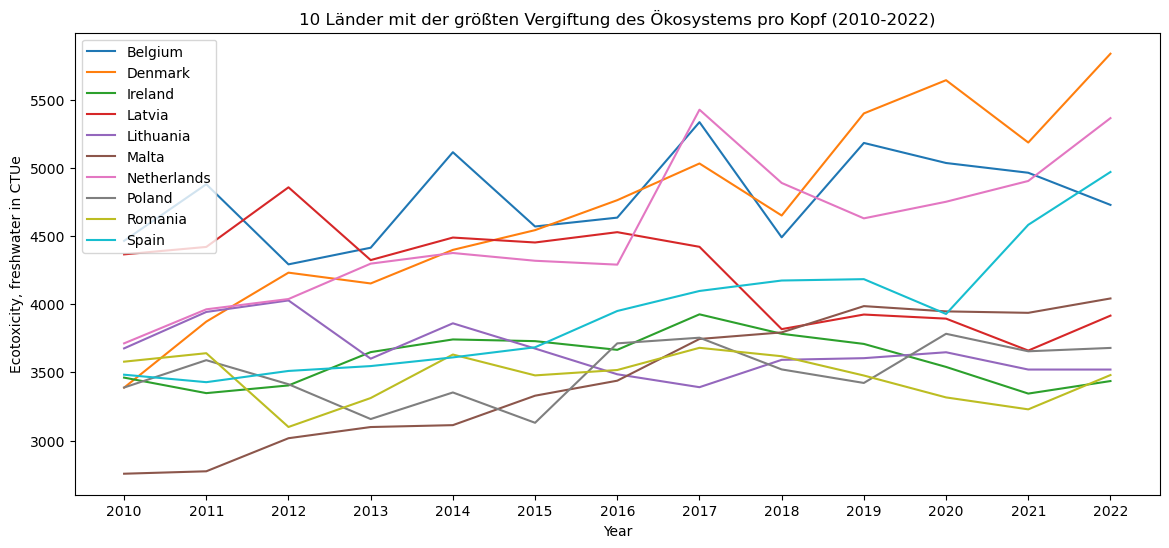

In [216]:
# Grafische Darstellung: Top 10 Länder Ecotoxicity, freshwater
ecotoxicity_top_10_countries =['Belgium', 'Denmark', 'Netherlands', 'Latvia', 'Spain', 'Lithuania', 'Ireland', 'Poland', 'Romania', 'Malta']
plt.figure(figsize=(14,6))
sns.lineplot(x='Year', y='Per Capita', hue='Country', palette='tab10', errorbar=None, data=capita_country_df[(capita_country_df['Impact category'] == 'ecotoxicity, freshwater') & (capita_country_df['Country'].isin(ecotoxicity_top_10_countries))])
plt.ylabel('Ecotoxicity, freshwater in CTUe')
plt.title('10 Länder mit der größten Vergiftung des Ökosystems pro Kopf (2010-2022)')
plt.xticks(ticks=years, labels=years)
plt.legend(loc='upper left')
plt.show()

Dänemark, Niederlande, Belgien und Spanien liegen bei der Vergiftung des Ökosystems ziemlich weit oben. 2022 liegen sie jeweils über 4500 CTUe. Zusätzlich zu ein paar bekannten Umweltsündern sind hier Lettland, Litauen, Polen und Rumänien hinzugekommen.

In [218]:
# Sortieren nach den Ländern mit den höchsten Particulate Matter-Werten -> 10 Länder herausfiltern
capita_country_impact_particulate = capita_country_impact_df.sort_values(by='particulate matter', ascending=False)
capita_country_impact_particulate.head(10)

Impact category  acidification  climate change  ecotoxicity, freshwater  \
Country                                                                   
Ireland               1.874687       86.917205              3595.038192   
Luxembourg            1.486881       80.165058              3441.031797   
Denmark               1.483642       76.765672              4699.108491   
Netherlands           1.446002       80.792882              4534.905325   
Italy                 1.416643       74.264328              3155.399892   
Malta                 1.413275       78.557829              3459.886167   
Sweden                1.347101       70.406819              3314.307531   
Finland               1.346000       65.998933              2906.736136   
Germany               1.315011       71.662772              3444.498227   
France                1.295821       67.346570              2899.146564   

Impact category  eutrophication, freshwater  eutrophication, marine  \
Country                                                               
Ireland                            0.007437                0.741999   
Luxembourg                         0.009510                0.574862   
Denmark                            0.008632                0.592360   
Netherlands                        0.009558                0.570291   
Italy                              0.008192                0.546531   
Malta                              0.010651                0.572397   
Sweden                             0.008384                0.534967   
Finland                            0.007370                0.522638   
Germany                            0.007551                0.498475   
France                             0.008053                0.505887   

Impact category  eutrophication, terrestrial  human toxicity, cancer  \
Country                                                                
Ireland                             8.178333            5.497721e-08   
Luxembourg                          6.421451            5.833351e-08   
Denmark                             6.428170            5.462426e-08   
Netherlands                         6.244131            6.001296e-08   
Italy                               6.083294            5.539611e-08   
Malta                               6.095809            5.793983e-08   
Sweden                              5.804446            5.374551e-08   
Finland                             5.779286            4.851454e-08   
Germany                             5.678893            5.702619e-08   
France                              5.583666            4.592499e-08   

Impact category  human toxicity, non-cancer  ionising radiation     land use  \
Country                                                                        
Ireland                            0.000002            1.239718  3113.744461   
Luxembourg                         0.000002            1.275031  3015.188214   
Denmark                            0.000002            1.208280  2812.777529   
Netherlands                        0.000002            1.319598  3116.865043   
Italy                              0.000002            1.248377  2855.725171   
Malta                              0.000002            1.271936  2902.794208   
Sweden                             0.000002            1.186728  2673.644623   
Finland                            0.000002            1.140911  2327.760654   
Germany                            0.000002            1.203332  2778.890090   
France                             0.000002            1.063245  2411.346776   

Impact category  ozone depletion  particulate matter  \
Country                                                
Ireland                 0.000053            0.000013   
Luxembourg              0.000062            0.000011   
Denmark                 0.000059            0.000011   
Netherlands             0.000062            0.000011   
Italy                   0.000058            0.000010   
Malta                   0.00

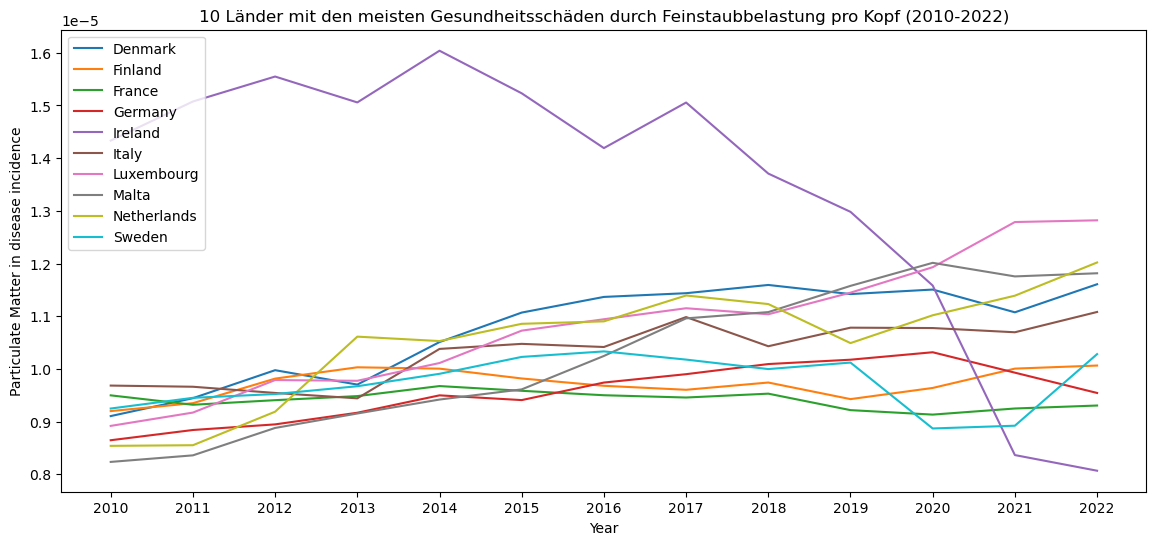

In [219]:
# Grafische Darstellung Top 10 Länder Particulate matter
particulate_top_10_countries =['Ireland', 'Luxembourg', 'Denmark', 'Netherlands', 'Italy', 'Malta', 'Sweden', 'Finland', 'Germany', 'France']
plt.figure(figsize=(14,6))
sns.lineplot(x='Year', y='Per Capita', hue='Country', palette='tab10', errorbar=None, data=capita_country_df[(capita_country_df['Impact category'] == 'particulate matter') & (capita_country_df['Country'].isin(particulate_top_10_countries))])
plt.ylabel('Particulate Matter in disease incidence')
plt.title('10 Länder mit den meisten Gesundheitsschäden durch Feinstaubbelastung pro Kopf (2010-2022)')
plt.xticks(ticks=years, labels=years)
plt.legend(loc='upper left')
plt.show()

Irland war hier sehr lange mit Abstand das Land mit der höchsten Feinstaubbelastung, konnte aber seit 2017 den Wert stetig senken. Seit ca. 2020 liegen nun Luxemburg, Malta, Spanien und Dänemark vorne.

In [221]:
# Sortieren nach den Ländern mit den höchsten Climate Change-Werten -> 10 Länder herausfiltern
capita_country_impact_climate = capita_country_impact_df.sort_values(by='climate change', ascending=False)
capita_country_impact_climate.head(10)

Impact category  acidification  climate change  ecotoxicity, freshwater  \
Country                                                                   
Ireland               1.874687       86.917205              3595.038192   
Netherlands           1.446002       80.792882              4534.905325   
Luxembourg            1.486881       80.165058              3441.031797   
Malta                 1.413275       78.557829              3459.886167   
Denmark               1.483642       76.765672              4699.108491   
Italy                 1.416643       74.264328              3155.399892   
Spain                 1.258413       73.372551              3934.127778   
Germany               1.315011       71.662772              3444.498227   
Sweden                1.347101       70.406819              3314.307531   
Belgium               1.099787       70.143537              4776.855889   

Impact category  eutrophication, freshwater  eutrophication, marine  \
Country                                                               
Ireland                            0.007437                0.741999   
Netherlands                        0.009558                0.570291   
Luxembourg                         0.009510                0.574862   
Malta                              0.010651                0.572397   
Denmark                            0.008632                0.592360   
Italy                              0.008192                0.546531   
Spain                              0.011397                0.490879   
Germany                            0.007551                0.498475   
Sweden                             0.008384                0.534967   
Belgium                            0.009548                0.451997   

Impact category  eutrophication, terrestrial  human toxicity, cancer  \
Country                                                                
Ireland                             8.178333            5.497721e-08   
Netherlands                         6.244131            6.001296e-08   
Luxembourg                          6.421451            5.833351e-08   
Malta                               6.095809            5.793983e-08   
Denmark                             6.428170            5.462426e-08   
Italy                               6.083294            5.539611e-08   
Spain                               5.307816            5.897985e-08   
Germany                             5.678893            5.702619e-08   
Sweden                              5.804446            5.374551e-08   
Belgium                             4.687560            5.888311e-08   

Impact category  human toxicity, non-cancer  ionising radiation     land use  \
Country                                                                        
Ireland                            0.000002            1.239718  3113.744461   
Netherlands                        0.000002            1.319598  3116.865043   
Luxembourg                         0.000002            1.275031  3015.188214   
Malta                              0.000002            1.271936  2902.794208   
Denmark                            0.000002            1.208280  2812.777529   
Italy                              0.000002            1.248377  2855.725171   
Spain                              0.000002            1.347536  3000.371228   
Germany                            0.000002            1.203332  2778.890090   
Sweden                             0.000002            1.186728  2673.644623   
Belgium                            0.000002            1.319239  2875.467914   

Impact category  ozone depletion  particulate matter  \
Country                                                
Ireland                 0.000053            0.000013   
Netherlands             0.000062            0.000011   
Luxembourg              0.000062            0.000011   
Malta                   0.000058            0.000010   
Denmark                 0.000059            0.000011   
Italy                   0.00

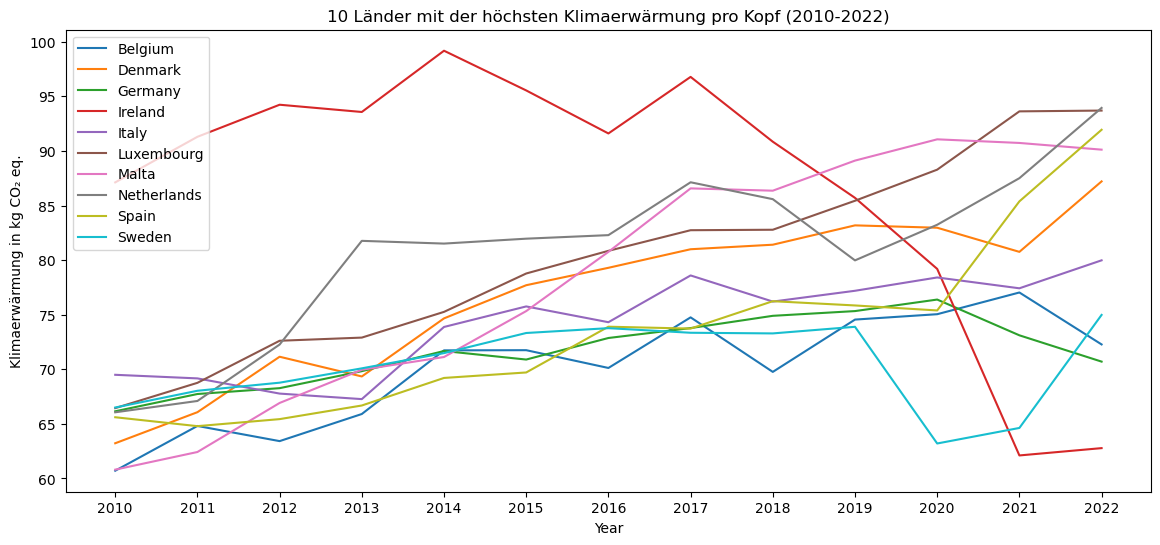

In [222]:
# Grafische Darstellung Top 10 Länder Climate Change
climate_top_10_countries =['Ireland', 'Netherlands', 'Luxembourg', 'Malta', 'Denmark', 'Italy', 'Spain', 'Germany', 'Sweden', 'Belgium']
plt.figure(figsize=(14,6))
sns.lineplot(x='Year', y='Per Capita', hue='Country', palette='tab10', errorbar=None, data=capita_country_df[(capita_country_df['Impact category'] == 'climate change') & (capita_country_df['Country'].isin(climate_top_10_countries))])
plt.ylabel('Klimaerwärmung in kg CO₂ eq.')
plt.title('10 Länder mit der höchsten Klimaerwärmung pro Kopf (2010-2022)')
plt.xticks(ticks=years, labels=years)
plt.legend(loc='upper left')
plt.show()

Auch hier lag hat Irland wieder weit vorne und konnte 2017 die Werte senken. Seit 2019 liegen nun Malta, Luxemburg, Niederlande und Dänemark vorne.

**Zwischenfazit**: In der EU werden die weltweiten Grenzwerte besonders stark bei der Vergiftung des Ökosystems überschritten (etwa 9 mal so hoch). Vor allem Belgien, Dänemark, Niederlande und Lettland haben hierzu beigetragen. Auch bei der Feinsstaubbelastung und den CO₂ Emissionen werden die Grenzwerte seit Jahren überschritten. Hier haben vor allem Irland, Niederlande und Luxemburg dazu beigetragen.

## Fazit & Ausblick

Generell zeigt der **Umweltschaden des Lebensmittelkonsums in der EU einen linearen Trend nach oben**. Vor allem **Fleisch- und Milchprodukte**, insbesondere Schweinefleisch und Käse, **tragen zu diesem Umweltschaden bei**. Sie wirken sich besonders auf die **Klimaerwärmung**, die **Feinsstaubbelastung** und die **Versauerung des Ökosystems** aus. Beim **Wasserverbrauch sind es vor allem Getränke**, vornehmlich Wein, die zu hohen Werten führen. Dagegen zählen Produkte wie **Linsen, Tofu, Sojadrinks, Kichererbsen und Quinoa zu den umweltfreundlichsten Lebensmitteln**. Bei all diesen Produkten wäre es nun interessant zu untersuchen, welche Prozesse genau zu den Werten beitragen. Sind es vor allem Produktionsprozesse oder Importe/Exporte, die die Werte beeinflussen? Die EU sollte auf jeden Fall künftig die Fleisch- und Milchproduktion verringern und die Produktion von Hülsenfrüchten und Produkten auf Hülsenfruchtbasis attraktiver machen.

Bei den **EU-Ländern** zeigen sich vor allem **Deutschland, Frankreich, Italien und Spanien** als Übeltäter. Wenn man allerdings die **Pro Kopf** Werte betrachtet sind es **Irland, die Niederlande, Dänemark und Luxemburg**. Hier wären vielleicht landesspezifische Analysen sinnvoll, um detaillierte Ergebnisse zu bekommen. Man sollte sich auch die Produktionsprozesse der einzelnen Länder anschauen und vor allem mit den **umweltfreundlicheren Ländern** wie **Ungarn, Bulgarien und Rumänien** vergleichen. So kann man besser nachvollziehen, woher diese Unterschiede kommen und daraus entsprechende Maßnahmen ziehen. So könnten z.B. Sanktionen für die umweltschädlichsten Länder verhängt werden bzw. monetäre Anreize für Länder, die besonders umweltfreundlich produzieren.

In den Kategorien **Vergiftung des Ökosystems, Klimaerwärmung und Feinstaubbelastung** werden die **weltweiten Grenzwerte von der EU seit Jahren stark überschritten**. Gerade bei diesen Kategorien sollte man also dringend eingreifen, um die Werte künftig niedriger zu halten. 

Meine Analyse hat sich auf die Produktgruppe Lebensmittel beschränkt. Man könnte sie nun auch **auf weitere Konsumbereiche ausbreiten**, da hierfür Daten der EU vorliegen. Ebenso beschränkt sich die Analyse lediglich auf die EU. Wenn es weltweite Daten geben sollte, ist auch eine **weltweite Analyse** sehr spannend.
Man kann mit der Analyse auch in eine tiefere Ebene gehen und sich die **Unternehmen anschauen, die die Lebensmittel produzieren**. Gibt es hier markante Unterschiede?

Die Datenanalyse gibt eine gute Einsicht in den Lebensmittelkonsum der EU und dessen Folgen für die Umwelt. Allerdings lässt sie **ökonomische und politische Zusammenhänge außer Acht**. Beispielsweise schneiden Fertigprodukte im Vergleich sehr gut ab. Allerdings bestehen diese Fertigprodukte wiederum aus anderen Lebensmitteln, wie z.B. Fleisch, deren Herstellung besonders umweltschädlich sein kann. 
Generell ist der repräsentative Warenkorb schon ein guter Ansatz, um den Lebensmittelkonsum der EU wiederzuspiegeln. Für umfangreichere Daten und somit eine bessere Datenanalyse müsste er allerdings erweitert werden.
Bei den EU-Ländern profitieren viele Ländern von der Produktion der Lebensmittel der anderen Länder bzw. viele Produktionsprozesse gehen durch mehrere EU-Länder. So wird in Deutschland z.B. sehr viel Fleisch produziert, es wird aber in Ländern wie Italien und Belgien weiterverarbeitet und verkauft. Die Arbeitskräfte könnten wiederum aus Polen und Rumänien kommen. Die Produktion ist also schwer immer auf ein Land zu beschränken und somit kann es auch schwierig sein, entsprechende Maßnahmen für einzelne Länder abzuleiten. Spannend wäre in dieser Hinsicht, sich die Profiteure der Fleisch- und Milchproduktion anzuschauen, also welche Länder ziehen am meisten Gewinn hieraus? Und wie kann es für diese Länder attraktiver machen, weniger tierische Produkte herzustellen, ohne dass sie Gewinnverluste machen?